# Mason's workbook on zestimate log errors

##### Due: 2022.01.07

In [1]:
#learn gong fu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mason_functions as mf
import scaler as sc
import wrangle_bits as wb
import sklearn.preprocessing

import env
import os
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

## Plan

# Wrangle

In [2]:
#define my sql query
sql = '''
SELECT *
FROM properties_2017
LEFT JOIN predictions_2017 pred USING(parcelid)
LEFT JOIN airconditioningtype USING(airconditioningtypeid)
LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
LEFT JOIN buildingclasstype USING(buildingclasstypeid)
LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
LEFT JOIN storytype USING(storytypeid)
LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
WHERE latitude IS NOT NULL 
AND longitude IS NOT NULL
AND propertylandusetypeid = 261
AND transactiondate LIKE "2017%%"
AND pred.id IN (SELECT MAX(id)
FROM predictions_2017
GROUP BY parcelid
HAVING MAX(transactiondate))
'''

#define my url
url = mf.get_db_url('zillow')

#set up an if-conditional to see if there is a .csv readily available, then load the data
if os.path.isfile('zillow_ol_pal.csv'):
    df = pd.read_csv('zillow_ol_pal.csv', index_col = 0)
else:
    df = pd.read_sql(sql, url)
    df.to_csv('zillow_ol_pal.csv')

In [3]:
pd.options.display.max_columns = 69
pd.options.display.max_rows = 69

In [4]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,3.5,4.0,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,1.0,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,1.0,2.0,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,2.0,3.0,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,3.0,4.0,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,261.0,2.0,NaN,NaN,1.0,12095076,781532,NaN,3.0,4.0,9.0,3.0,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,34145202.0,-118179824.0,63000.0,1.0,NaN,NaN,NaN,1.0,0101,PSR2,6.037461e+07,47019.0,3101.0,274684.0,96293.0,0.0,NaN,1.0,NaN,NaN,1950.0,NaN,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,6,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52319 non-null  float64
 3   heatingorsystemtypeid         33849 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13615 non-null  float64
 7   parcelid                      52319 non-null  int64  
 8   id                            52319 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52319 non-null  float64
 11  bedroomcnt                    52319 non-null  float64
 12  buildingqualitytypeid         33654 non-null  float64
 13  c

In [6]:
#verify length of dataframe is the same as the number of unique parcel ids
df.parcelid.nunique()

52319

In [7]:
#calculate column nulls
column_nulls = wb.calculate_column_nulls(df)

In [8]:
#column nulls at a glance
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
finishedsquarefeet13,52319,1.00000,100.0%
buildingclassdesc,52319,1.00000,100.0%
buildingclasstypeid,52319,1.00000,100.0%
finishedsquarefeet15,52319,1.00000,100.0%
storydesc,52272,0.99910,99.91%
storytypeid,52272,0.99910,99.91%
basementsqft,52272,0.99910,99.91%
yardbuildingsqft26,52256,0.99880,99.88%
architecturalstyletypeid,52249,0.99866,99.87%
architecturalstyledesc,52249,0.99866,99.87%


In [9]:
#calculate row nulls
row_nulls = wb.calculate_row_nulls(df)

In [10]:
#row nulls at a glance
row_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
28006,48,0.69565,70%
8954,48,0.69565,70%
41347,47,0.68116,68%
13356,46,0.66667,67%
21989,45,0.65217,65%
...,...,...,...
44684,24,0.34783,35%
83,24,0.34783,35%
37444,24,0.34783,35%
39391,23,0.33333,33%


In [11]:
#handle missing nulls 
#(drop any column with over half of the values missing and any rows with over half missing after dropping columns)
df = wb.handle_nulls(df, .5 , .5)

In [12]:
#calculate remaining column nulls
column_nulls = wb.calculate_column_nulls(df)

In [13]:
#remaining column nulls at a glance
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
buildingqualitytypeid,18665,0.35675,35.68%
unitcnt,18558,0.35471,35.47%
propertyzoningdesc,18558,0.35471,35.47%
heatingorsystemdesc,18470,0.35303,35.3%
heatingorsystemtypeid,18470,0.35303,35.3%
regionidcity,1036,0.01980,1.98%
lotsizesquarefeet,366,0.00700,0.7%
finishedsquarefeet12,246,0.00470,0.47%
fullbathcnt,135,0.00258,0.26%
calculatedbathnbr,135,0.00258,0.26%


In [14]:
#calculate remaining row nulls
row_nulls = wb.calculate_row_nulls(df)

In [15]:
#remaining row nulls at a glance
row_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
28006,14,0.40000,40%
8954,14,0.40000,40%
41347,13,0.37143,37%
48475,12,0.34286,34%
32311,12,0.34286,34%
...,...,...,...
21482,0,0.00000,0%
21483,0,0.00000,0%
21484,0,0.00000,0%
21486,0,0.00000,0%


In [16]:
#set an empty list
okay_to_drop = []

#commence loop through index of column nulls
for n in range(len(column_nulls)):
    
    #set up conditional to see if ratio of values missing in column is less than 2%
    if column_nulls.iloc[n].null_ratio < .2:
        
        #add features to list 
        okay_to_drop.append(column_nulls.index[n])
        
#verify
#print(okay_to_drop)

#commence loop through list        
for feature in okay_to_drop:
    
    #drop rows where there are missing values in the columns specified
    df = df[df[feature].notnull()]

In [17]:
#calculate remaining nulls
column_nulls = wb.calculate_column_nulls(df)

In [18]:
#pull up the list of column nulls to verify dropped rows
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
buildingqualitytypeid,17939,0.35481,35.48%
propertyzoningdesc,17873,0.35351,35.35%
unitcnt,17856,0.35317,35.32%
heatingorsystemdesc,17764,0.35135,35.14%
heatingorsystemtypeid,17764,0.35135,35.14%
propertylandusetypeid,0,0.00000,0.0%
taxvaluedollarcnt,0,0.00000,0.0%
roomcnt,0,0.00000,0.0%
yearbuilt,0,0.00000,0.0%
structuretaxvaluedollarcnt,0,0.00000,0.0%


What is propertyzoningdesc? There is no corresponding table

In [19]:
#pull up values for propertyzoningdesc column
df.propertyzoningdesc.value_counts(dropna = False)

NaN          17873
LAR1          6404
LARS          1378
LBR1N         1107
SCUR2          611
             ...  
CLHC             1
CLRM*            1
BRR17500*        1
PDRPD151*        1
CVR1YY           1
Name: propertyzoningdesc, Length: 1237, dtype: int64

In [20]:
#create final list of columns to drop
final_drops = []

In [21]:
#add column to list
final_drops.append('propertyzoningdesc')

In [22]:
#pull up values for heatingsystemdesc
df.heatingorsystemdesc.value_counts(dropna = False)

Central       19897
NaN           17764
Floor/Wall    12330
Forced air      502
Solar            36
None             16
Baseboard         7
Radiant           4
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

Okay, I'll come back for this

In [23]:
#pull up values for unitcnt
df.unitcnt.value_counts(dropna = False)

1.0    32684
NaN    17856
2.0       18
3.0        1
Name: unitcnt, dtype: int64

In [24]:
#map null values to the value of 1
df.unitcnt = df.unitcnt.map({np.nan: 1,
               1: 1,
               2: 2,
               3: 3})

In [25]:
#verify
df.unitcnt.value_counts(dropna = False)

1    50540
2       18
3        1
Name: unitcnt, dtype: int64

In [26]:
#pull up values for buildingqualitytypeid
df.buildingqualitytypeid.value_counts(dropna = False).sort_index(ascending = False)

12.0       76
11.0      482
10.0      211
9.0      1035
8.0      7981
7.0      3125
6.0     10125
5.0      1469
4.0      7967
3.0       141
2.0         4
1.0         4
NaN     17939
Name: buildingqualitytypeid, dtype: int64

There is nothing in the database that I see that helps me identify what kind of feature this is. Drop

In [27]:
#add to the list of final drops
final_drops.append('buildingqualitytypeid')

In [28]:
#drop columns on list
df = df.drop(columns = final_drops)

In [29]:
#calculate remaining column nulls
column_nulls = wb.calculate_column_nulls(df)

In [30]:
#pull up list of sorted column nulls
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
heatingorsystemtypeid,17764,0.35135,35.14%
heatingorsystemdesc,17764,0.35135,35.14%
assessmentyear,0,0.00000,0.0%
regionidzip,0,0.00000,0.0%
roomcnt,0,0.00000,0.0%
unitcnt,0,0.00000,0.0%
yearbuilt,0,0.00000,0.0%
structuretaxvaluedollarcnt,0,0.00000,0.0%
taxvaluedollarcnt,0,0.00000,0.0%
propertylandusetypeid,0,0.00000,0.0%


In [31]:
#age as a continuous variable makes more sense
df['age'] = 2017 - df['yearbuilt']
df = df.drop(columns = 'yearbuilt')
df['abs_logerror'] = df['logerror'].abs()

In [32]:
#get a list of numerical columns 
quant_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'unitcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'age']

In [33]:
#get info on numeric columns
df[quant_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50559 entries, 0 to 52318
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   50559 non-null  float64
 1   bedroomcnt                    50559 non-null  float64
 2   calculatedbathnbr             50559 non-null  float64
 3   unitcnt                       50559 non-null  int64  
 4   calculatedfinishedsquarefeet  50559 non-null  float64
 5   fullbathcnt                   50559 non-null  float64
 6   lotsizesquarefeet             50559 non-null  float64
 7   roomcnt                       50559 non-null  float64
 8   structuretaxvaluedollarcnt    50559 non-null  float64
 9   taxvaluedollarcnt             50559 non-null  float64
 10  landtaxvaluedollarcnt         50559 non-null  float64
 11  taxamount                     50559 non-null  float64
 12  age                           50559 non-null  float64
dtypes

In [34]:
#set parcel id to index
df = df.set_index('parcelid')

In [35]:
#assign dataframe columns to a list
df_columns = df.columns.to_list()

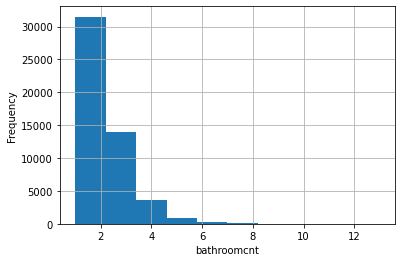

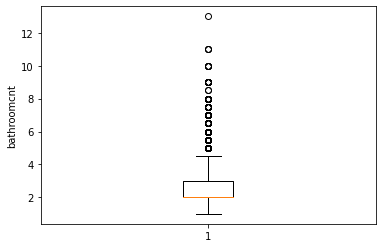

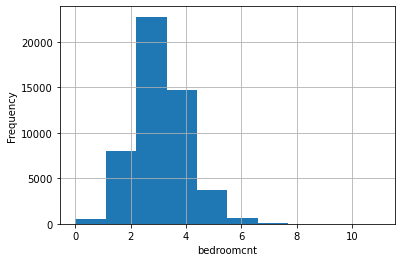

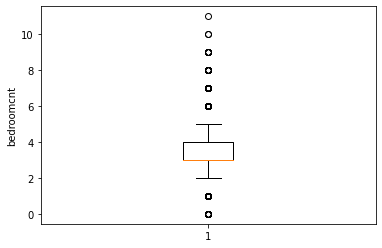

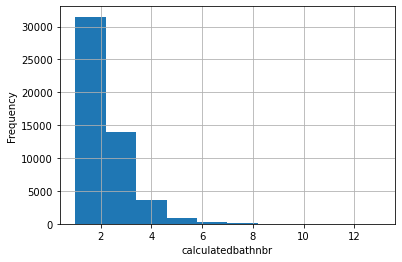

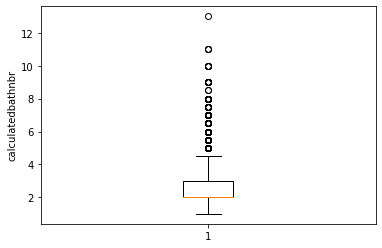

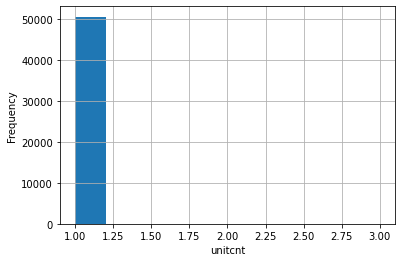

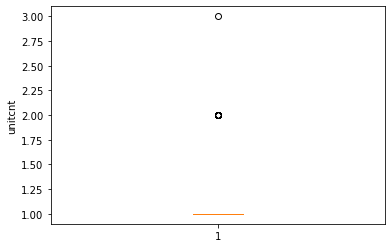

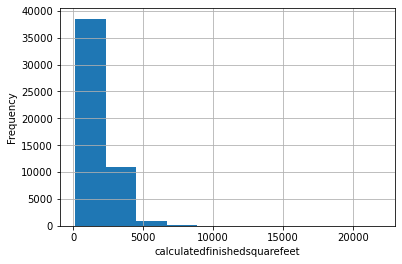

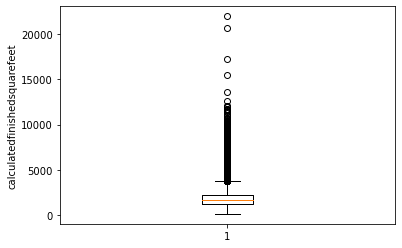

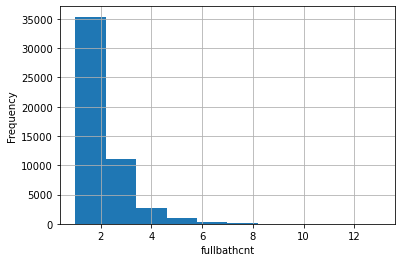

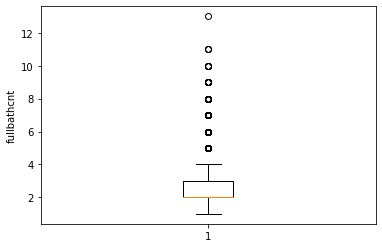

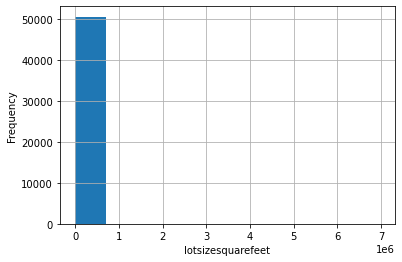

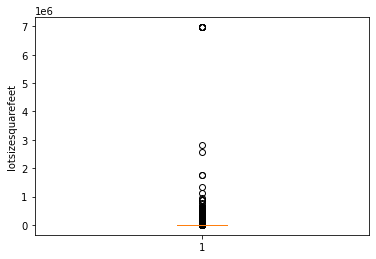

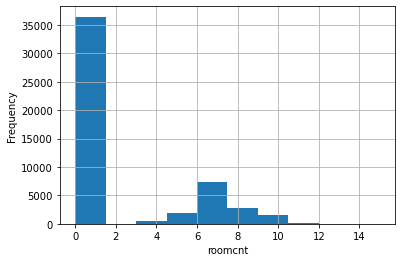

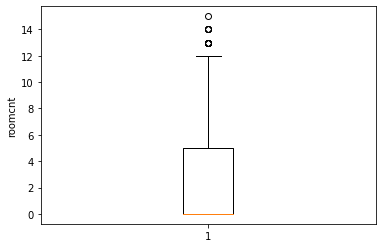

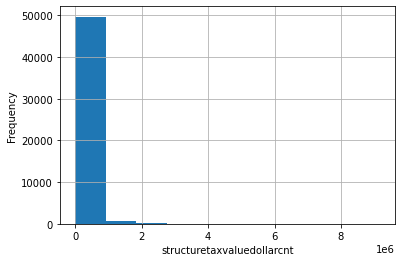

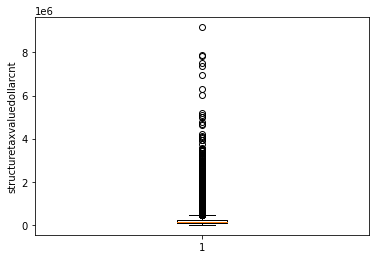

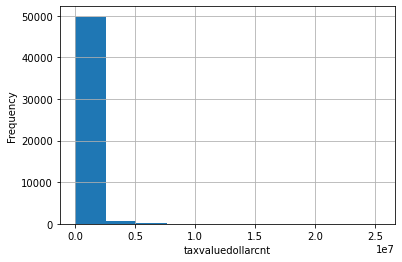

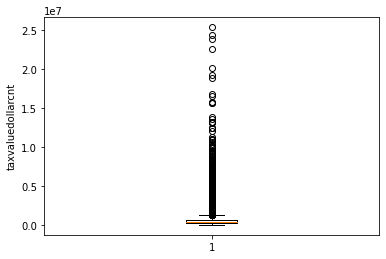

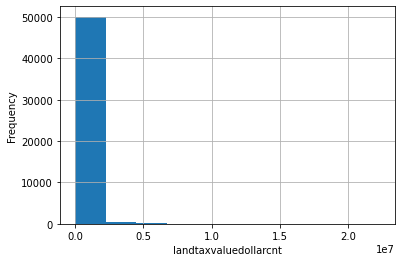

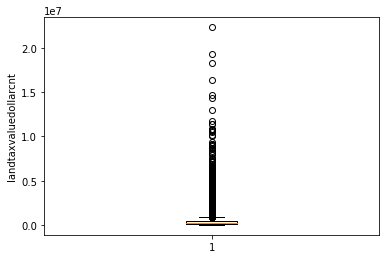

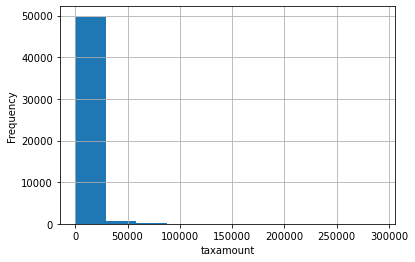

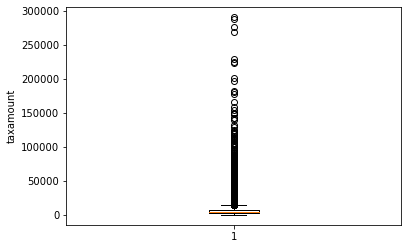

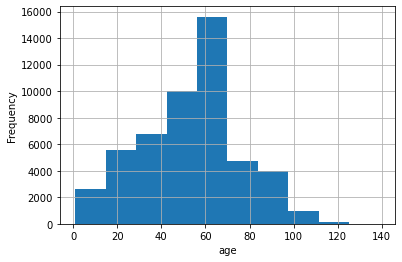

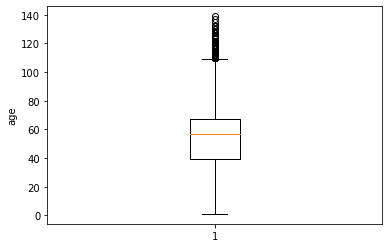

In [36]:
#loop through this list to view distributions of numeric columns
for cat in quant_vars:
    df[cat].hist()
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();
    plt.boxplot(df[cat])
    plt.ylabel(cat)
    plt.show();

In [37]:
#loop through the list of columns
for col in quant_vars:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles
    
    iqr = q3 - q1   # calculate interquartile range
    
    upper_bound = q3 + 1 * iqr   # get upper bound
    lower_bound = q1 - 1 * iqr   # get lower bound
    
    dft = df[(df[col] > lower_bound) & (df[col] < upper_bound)] # return dataframe without outliers

In [38]:
#verify some entries were removed (pull up dataframe info)
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47235 entries, 14297519 to 12826780
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         47235 non-null  float64
 1   heatingorsystemtypeid         30488 non-null  float64
 2   id                            47235 non-null  int64  
 3   bathroomcnt                   47235 non-null  float64
 4   bedroomcnt                    47235 non-null  float64
 5   calculatedbathnbr             47235 non-null  float64
 6   calculatedfinishedsquarefeet  47235 non-null  float64
 7   finishedsquarefeet12          47235 non-null  float64
 8   fips                          47235 non-null  float64
 9   fullbathcnt                   47235 non-null  float64
 10  latitude                      47235 non-null  float64
 11  longitude                     47235 non-null  float64
 12  lotsizesquarefeet             47235 non-null  floa

In [39]:
#keep df name orthodox
df = dft

In [40]:
#drop the one row where the heating or system id is 24
df = df[df.heatingorsystemtypeid != 24]

In [41]:
#a look at the value counts 
df.rawcensustractandblock.value_counts().sort_index(ascending = False)

6.111009e+07    1
6.111009e+07    1
6.111009e+07    1
6.111009e+07    1
6.111009e+07    1
               ..
6.037101e+07    2
6.037101e+07    1
6.037101e+07    1
6.037101e+07    1
6.037101e+07    1
Name: rawcensustractandblock, Length: 28652, dtype: int64

In [42]:
#look at values
df.censustractandblock.value_counts().sort_values(ascending = True)

6.059100e+13     1
6.037301e+13     1
6.037535e+13     1
6.111004e+13     1
6.037552e+13     1
                ..
6.037194e+13    20
6.037142e+13    21
6.059032e+13    21
6.059032e+13    24
6.037920e+13    32
Name: censustractandblock, Length: 28650, dtype: int64

In [43]:
#assign new column to object-values (did not work) for the raw census tract and block numbers
df['tractsense'] = df['rawcensustractandblock'].astype('object')

In [44]:
#pull up value counts 
df.tractsense.value_counts()

6.037920e+07    32
6.059032e+07    24
6.059032e+07    21
6.037142e+07    21
6.037194e+07    20
                ..
6.059002e+07     1
6.037555e+07     1
6.059063e+07     1
6.059111e+07     1
6.037574e+07     1
Name: tractsense, Length: 28652, dtype: int64

In [45]:
#raw census data sorted (what is this feature, really?)
df.tractsense.sort_values(ascending = False)

parcelid
17162024    61110091.001017
17162450    61110091.001004
17162416    61110091.001002
17169061    61110089.002025
17167911    61110089.002022
                 ...       
11001108    60371011.101011
11002186    60371011.101009
11002100    60371011.101002
11002060    60371011.101001
11002019       60371011.101
Name: tractsense, Length: 47234, dtype: object

In [46]:
#verify all properties are single, then add to the drop list (not a useful feature)
df.propertylandusedesc.value_counts(), df.propertylandusetypeid.value_counts()

(Single Family Residential    47234
 Name: propertylandusedesc, dtype: int64,
 261.0    47234
 Name: propertylandusetypeid, dtype: int64)

In [47]:
#add these columns to the list of columns to drop
final_drops.append('censustractandblock')
final_drops.append('rawcensustractandblock')
final_drops.append('tractsense')
final_drops.append('finishedsquarefeet12')
final_drops.append('regionidcity')
final_drops.append('regionidcounty')
final_drops.append('id.1')
final_drops.append('propertylandusedesc')
final_drops.append('propertylandusetypeid')
                   
#remove these from the list, cannot drop again
final_drops.remove('buildingqualitytypeid')
final_drops.remove('propertyzoningdesc')

In [48]:
#verify list
final_drops

['censustractandblock',
 'rawcensustractandblock',
 'tractsense',
 'finishedsquarefeet12',
 'regionidcity',
 'regionidcounty',
 'id.1',
 'propertylandusedesc',
 'propertylandusetypeid']

In [49]:
#verify column info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47234 entries, 14297519 to 12826780
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         47234 non-null  float64
 1   heatingorsystemtypeid         30487 non-null  float64
 2   id                            47234 non-null  int64  
 3   bathroomcnt                   47234 non-null  float64
 4   bedroomcnt                    47234 non-null  float64
 5   calculatedbathnbr             47234 non-null  float64
 6   calculatedfinishedsquarefeet  47234 non-null  float64
 7   finishedsquarefeet12          47234 non-null  float64
 8   fips                          47234 non-null  float64
 9   fullbathcnt                   47234 non-null  float64
 10  latitude                      47234 non-null  float64
 11  longitude                     47234 non-null  float64
 12  lotsizesquarefeet             47234 non-null  floa

In [50]:
#check values for id column
df.id.value_counts(ascending = False)

749775     1
1833738    1
34703      1
1293058    1
3126       1
          ..
490789     1
2581798    1
1469735    1
2168104    1
657407     1
Name: id, Length: 47234, dtype: int64

In [51]:
#convert id to object type
df.id = df.id.astype(str)
df.tractsense = df.tractsense.astype(str)
df.assessmentyear = df.assessmentyear.astype(str)
df.regionidzip = df.regionidzip.astype(int)
df.regionidzip = df.regionidzip.astype(str)

#reduce noice by chainging columns values to integers instead of decimals
df.fips = df.fips.astype(int)
df.age = df.age.astype(int)
df.lotsizesquarefeet = df.lotsizesquarefeet.astype(int)
df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet.astype(int)
df.fullbathcnt = df.fullbathcnt.astype(int)

In [52]:
df.heatingorsystemtypeid.value_counts()

2.0     18843
7.0     11089
6.0       499
20.0       27
13.0       16
1.0         7
18.0        4
10.0        2
Name: heatingorsystemtypeid, dtype: int64

In [53]:
#verify list again
final_drops

['censustractandblock',
 'rawcensustractandblock',
 'tractsense',
 'finishedsquarefeet12',
 'regionidcity',
 'regionidcounty',
 'id.1',
 'propertylandusedesc',
 'propertylandusetypeid']

In [54]:
#drop the columns deemed superfluous
df = df.drop(columns = final_drops)

In [55]:
#verify changes to df (pull up dataframe info)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47234 entries, 14297519 to 12826780
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   heatingorsystemtypeid         30487 non-null  float64
 1   id                            47234 non-null  object 
 2   bathroomcnt                   47234 non-null  float64
 3   bedroomcnt                    47234 non-null  float64
 4   calculatedbathnbr             47234 non-null  float64
 5   calculatedfinishedsquarefeet  47234 non-null  int64  
 6   fips                          47234 non-null  int64  
 7   fullbathcnt                   47234 non-null  int64  
 8   latitude                      47234 non-null  float64
 9   longitude                     47234 non-null  float64
 10  lotsizesquarefeet             47234 non-null  int64  
 11  propertycountylandusecode     47234 non-null  object 
 12  regionidzip                   47234 non-null  obje

In [56]:
#juxtapose tax value columns
df.structuretaxvaluedollarcnt.value_counts(ascending = False), df.taxvaluedollarcnt.value_counts(ascending = False)

(100000.0    44
 200000.0    32
 32489.0     26
 95000.0     25
 90000.0     24
             ..
 243883.0     1
 317570.0     1
 70619.0      1
 522828.0     1
 154255.0     1
 Name: structuretaxvaluedollarcnt, Length: 34200, dtype: int64,
 455000.0    29
 600000.0    25
 500000.0    23
 450000.0    21
 585000.0    21
             ..
 153224.0     1
 156280.0     1
 256410.0     1
 119668.0     1
 409961.0     1
 Name: taxvaluedollarcnt, Length: 35608, dtype: int64)

In [57]:
#rename all columns to be easier
df = df.rename(columns = {'heatingorsystemtypeid': 'heat_id',
                          'id': 'transaction_id',
                          'bathroomcnt': 'bathrooms',
                          'bedroomcnt': 'bedrooms',
                          'calculatedbathnbr': 'bath_bed',
                          'calculatedfinishedsquarefeet': 'square_feet',
                          'fips': 'fips_id',
                          'fullbathcnt': 'full_bathrooms',
                          'lotsizesquarefeet': 'lot_size',
                          'propertycountylandusecode': 'property_landuse_code',
                          'regionidzip': 'zip_code',
                          'roomcnt': 'rooms',
                          'unitcnt': 'units',
                          'structuretaxvaluedollarcnt': 'structure_tax_value',
                          'taxvaluedollarcnt': 'tax_value',
                          'assessmentyear': 'year_assessed',
                          'landtaxvaluedollarcnt': 'land_tax_value',
                          'taxamount': 'tax_amount',
                          'logerror': 'log_error',
                          'transactiondate': 'transaction_date',
                          'heatingorsystemdesc' : 'heat_system_desc'
                         })

In [58]:
#check column info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47234 entries, 14297519 to 12826780
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   heat_id                30487 non-null  float64
 1   transaction_id         47234 non-null  object 
 2   bathrooms              47234 non-null  float64
 3   bedrooms               47234 non-null  float64
 4   bath_bed               47234 non-null  float64
 5   square_feet            47234 non-null  int64  
 6   fips_id                47234 non-null  int64  
 7   full_bathrooms         47234 non-null  int64  
 8   latitude               47234 non-null  float64
 9   longitude              47234 non-null  float64
 10  lot_size               47234 non-null  int64  
 11  property_landuse_code  47234 non-null  object 
 12  zip_code               47234 non-null  object 
 13  rooms                  47234 non-null  float64
 14  units                  47234 non-null  int64

In [59]:
#set new county column equal to the fips id column
df['county'] = df['fips_id']

#map fips ids to respective counties
df.county = df.county.map({6037: 'LA_county',
                          6059: 'orange_county',
                          6111: 'ventura_county'
                          })

#get dummies
dummy_df = pd.get_dummies(df.county, drop_first = False)

In [60]:
#concatenate the data frames
df = pd.concat([dummy_df, df], axis = 1)

#check it
df.head()

,LA_county,orange_county,ventura_county,heat_id,transaction_id,bathrooms,bedrooms,bath_bed,square_feet,fips_id,full_bathrooms,latitude,longitude,lot_size,property_landuse_code,zip_code,rooms,units,structure_tax_value,tax_value,year_assessed,land_tax_value,tax_amount,log_error,transaction_date,heat_system_desc,age,abs_logerror,county
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14297519,0,1,0,NaN,1727539,3.5,4.0,3.5,3100,6059,3,33634931.0,-117869207.0,4506,122,96978,0.0,1,485713.0,1023282.0,2016.0,537569.0,11013.72,0.025595,2017-01-01,NaN,19,0.025595,orange_county
17052889,0,0,1,NaN,1387261,1.0,2.0,1.0,1465,6111,1,34449266.0,-119281531.0,12647,1110,97099,5.0,1,88000.0,464000.0,2016.0,376000.0,5672.48,0.055619,2017-01-01,NaN,50,0.055619,ventura_county
14186244,0,1,0,NaN,11677,2.0,3.0,2.0,1243,6059,2,33886168.0,-117823170.0,8432,122,97078,6.0,1,85289.0,564778.0,2016.0,479489.0,6488.30,0.005383,2017-01-01,NaN,55,0.005383,orange_county
12177905,1,0,0,2.0,2288172,3.0,4.0,3.0,2376,6037,3,34245180.0,-118240722.0,13038,0101,96330,0.0,1,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Central,47,0.103410,LA_county
12095076,1,0,0,2.0,781532,3.0,4.0,3.0,2962,6037,3,34145202.0,-118179824.0,63000,0101,96293,0.0,1,276684.0,773303.0,2016.0,496619.0,9516.26,-0.001011,2017-01-01,Central,67,0.001011,LA_county


In [61]:
#confirm dataframe of NaNs is present
fill_these = df[df['heat_id'].isnull()]
fill_these.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16747 entries, 14297519 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              16747 non-null  uint8  
 1   orange_county          16747 non-null  uint8  
 2   ventura_county         16747 non-null  uint8  
 3   heat_id                0 non-null      float64
 4   transaction_id         16747 non-null  object 
 5   bathrooms              16747 non-null  float64
 6   bedrooms               16747 non-null  float64
 7   bath_bed               16747 non-null  float64
 8   square_feet            16747 non-null  int64  
 9   fips_id                16747 non-null  int64  
 10  full_bathrooms         16747 non-null  int64  
 11  latitude               16747 non-null  float64
 12  longitude              16747 non-null  float64
 13  lot_size               16747 non-null  int64  
 14  property_landuse_code  16747 non-null  objec

In [62]:
#drop nulls to run model to impute
df = df[df.heat_id.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30487 entries, 12177905 to 12826780
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              30487 non-null  uint8  
 1   orange_county          30487 non-null  uint8  
 2   ventura_county         30487 non-null  uint8  
 3   heat_id                30487 non-null  float64
 4   transaction_id         30487 non-null  object 
 5   bathrooms              30487 non-null  float64
 6   bedrooms               30487 non-null  float64
 7   bath_bed               30487 non-null  float64
 8   square_feet            30487 non-null  int64  
 9   fips_id                30487 non-null  int64  
 10  full_bathrooms         30487 non-null  int64  
 11  latitude               30487 non-null  float64
 12  longitude              30487 non-null  float64
 13  lot_size               30487 non-null  int64  
 14  property_landuse_code  30487 non-null  objec

I'm going to impute the heat id with values from a random forest model

In [63]:
#split data to impute heat_id with random forest model
class_train, class_validate, class_test = wb.class_split_data(df, target = 'heat_id')

In [64]:
#set up continuous features
quant_vars = ['bathrooms', 'bedrooms', 'bath_bed', 'square_feet', 'full_bathrooms', 'lot_size', 'rooms', 'units', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'age']
print(quant_vars)
len(quant_vars)

['bathrooms', 'bedrooms', 'bath_bed', 'square_feet', 'full_bathrooms', 'lot_size', 'rooms', 'units', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'age']


13

In [65]:
#scale classifying data
c_train_scaled, c_validate_scaled, c_test_scaled, c_scaler = sc.robust_scaler(class_train, class_validate, class_test, quant_vars)

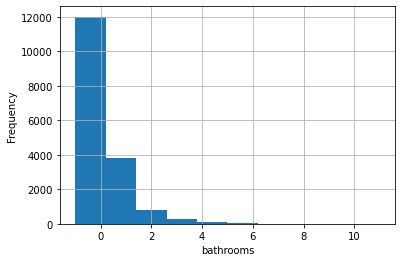

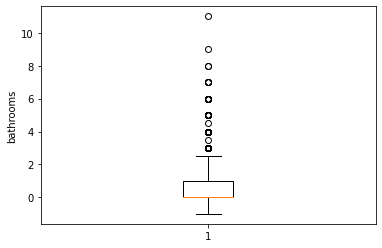

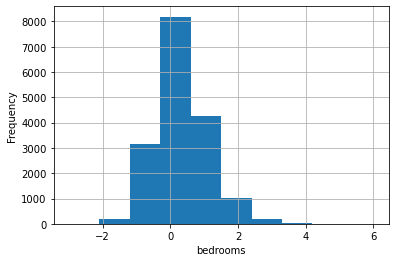

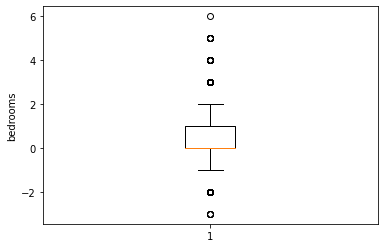

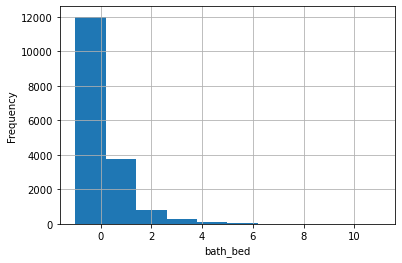

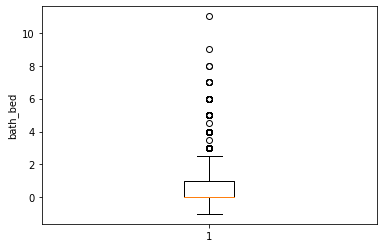

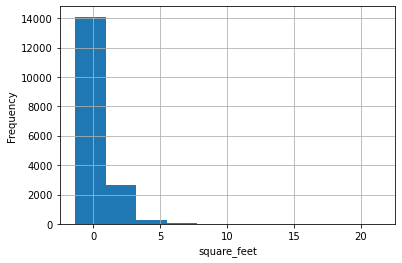

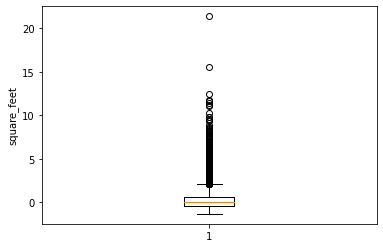

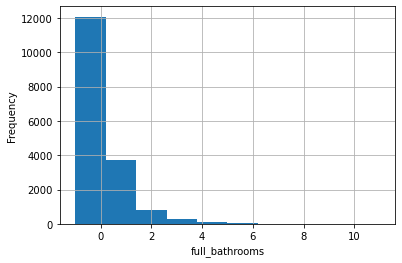

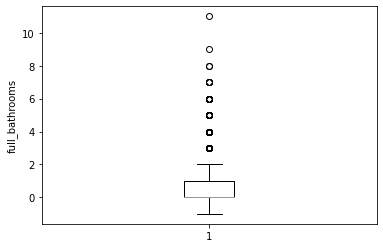

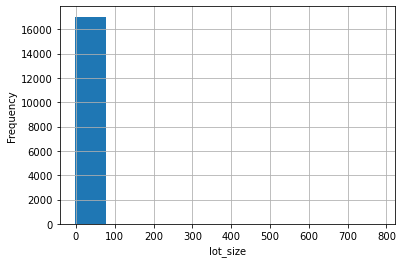

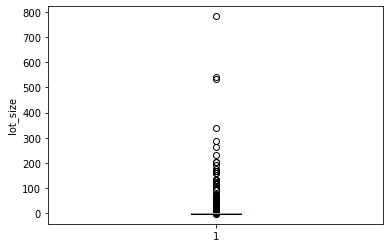

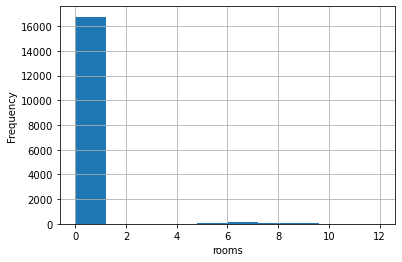

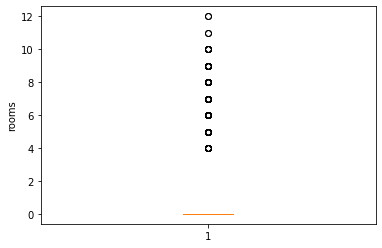

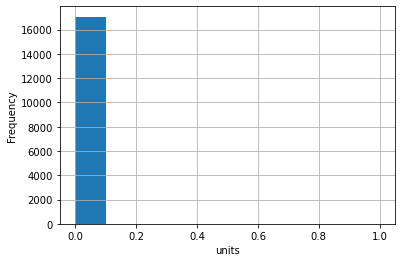

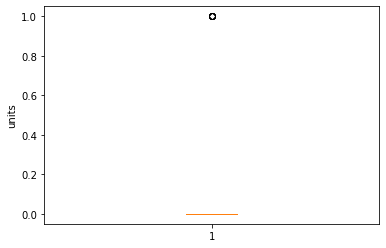

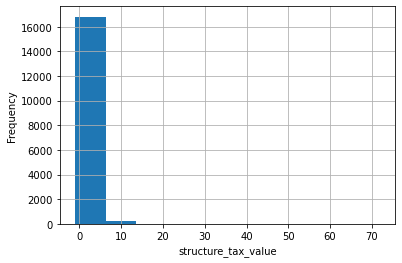

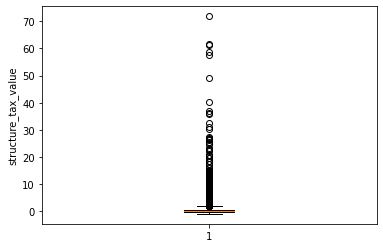

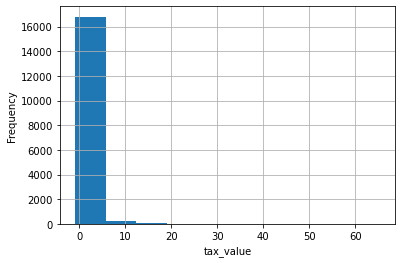

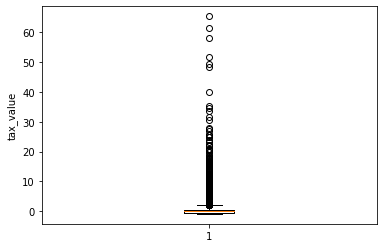

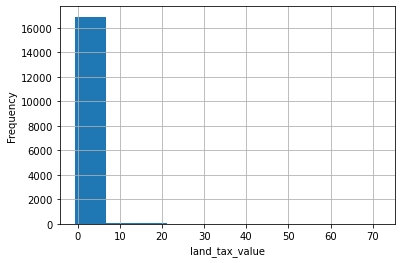

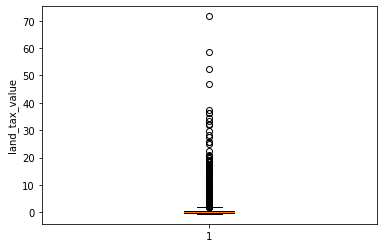

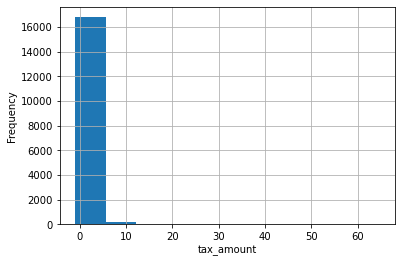

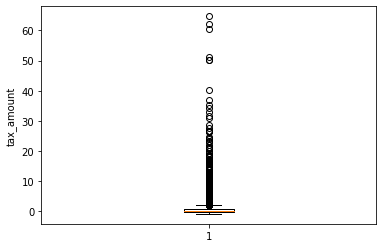

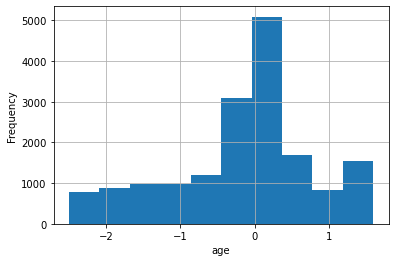

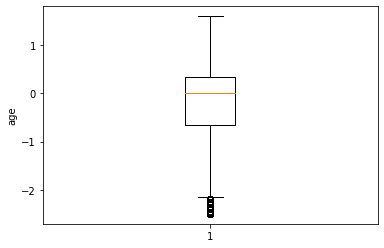

In [66]:
#get list
train_columns = c_train_scaled.columns.to_list()

#loop through this list to view distributions of scaled numeric columns
for cat in quant_vars:
    c_train_scaled[cat].hist()
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();
    plt.boxplot(c_train_scaled[cat])
    plt.ylabel(cat)
    plt.show();

In [67]:
#set up modeling data
CX_train = c_train_scaled
cy_train = class_train.heat_id

CX_validate = c_validate_scaled
cy_validate = class_validate.heat_id

CX_test = c_test_scaled
cy_test = class_test.heat_id

In [68]:
#set up a baseline prediction
baseline = cy_train.mode()

#boolean mask to verify whether or not the id matches up with the prediction
match = cy_train == 2

#establish baseline accuracy
baseline_accuracy = match.mean()
print(f'Baseline accuracy is {round(baseline_accuracy * 100)}%')

Baseline accuracy is 62%


In [69]:
from sklearn.ensemble import RandomForestClassifier

#create model to classify heat_id
rf = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 421)

#fit the model to the training data
rf.fit(CX_train, cy_train)

#predict
class_train['predictions'] = rf.predict(CX_train)

#confusion matrix (crosstab between actual vs predicted)
con_matrix = pd.crosstab(class_train.predictions, class_train.heat_id)
con_matrix = pd.DataFrame(con_matrix)
con_matrix

heat_id,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions,,,,,,,,
2.0,0,9517,3,894,1,0,0,14
6.0,4,0,274,4,0,9,2,0
7.0,0,1035,2,5312,0,0,0,1


In [70]:
#calculate accuracy
accuracy = (con_matrix.loc[2.0][2.0] + con_matrix.loc[6.0][6.0] + con_matrix.loc[7.0][7.0]) / (con_matrix.loc[2.0].sum() + con_matrix.loc[6.0].sum() + con_matrix[7.0].sum())
print(f'In-sample accuracy is {round(accuracy * 100)}%')

In-sample accuracy is 89%


In [71]:
#valid or invalid? predict on validate set

#predict
class_validate['predictions'] = rf.predict(CX_validate)

#confusion matrix (crosstab between actual vs predicted)
con_matrix = pd.crosstab(class_validate.predictions, class_validate.heat_id)
con_matrix = pd.DataFrame(con_matrix)
con_matrix

heat_id,1.0,2.0,6.0,7.0,10.0,13.0,18.0,20.0
predictions,,,,,,,,
2.0,0,4038,0,414,0,0,0,5
6.0,2,0,117,2,1,4,1,0
7.0,0,484,3,2245,0,0,0,1


In [72]:
#calculate accuracy
accuracy = (con_matrix.loc[2.0][2.0] + con_matrix.loc[6.0][6.0] + con_matrix.loc[7.0][7.0]) / (con_matrix.loc[2.0].sum() + con_matrix.loc[6.0].sum() + con_matrix[7.0].sum())
print(f'Out-of-sample accuracy is {round(accuracy * 100)}%')

Out-of-sample accuracy is 88%


In [73]:
#predict on test set

class_test['predictions'] = rf.predict(CX_test)

con_matrix = pd.crosstab(class_test.predictions, class_test.heat_id)
con_matrix = pd.DataFrame(con_matrix)
con_matrix

heat_id,1.0,2.0,6.0,7.0,13.0,18.0,20.0
predictions,,,,,,,
2.0,0,3391,0,356,0,0,6
6.0,1,0,99,3,3,1,0
7.0,0,378,1,1859,0,0,0


In [74]:
#calculate accuracy
accuracy = (con_matrix.loc[2.0][2.0] + con_matrix.loc[6.0][6.0] + con_matrix.loc[7.0][7.0]) / (con_matrix.loc[2.0].sum() + con_matrix.loc[6.0].sum() + con_matrix[7.0].sum())
print(f'Accuracy is {round(accuracy * 100)}%')

Accuracy is 88%


I really like beating the baseline accuracy of 62% by 16%, so i'll move forward with this model to impute my null heat_id values

In [75]:
#bring up dataframe info for last looks
fill_these.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16747 entries, 14297519 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              16747 non-null  uint8  
 1   orange_county          16747 non-null  uint8  
 2   ventura_county         16747 non-null  uint8  
 3   heat_id                0 non-null      float64
 4   transaction_id         16747 non-null  object 
 5   bathrooms              16747 non-null  float64
 6   bedrooms               16747 non-null  float64
 7   bath_bed               16747 non-null  float64
 8   square_feet            16747 non-null  int64  
 9   fips_id                16747 non-null  int64  
 10  full_bathrooms         16747 non-null  int64  
 11  latitude               16747 non-null  float64
 12  longitude              16747 non-null  float64
 13  lot_size               16747 non-null  int64  
 14  property_landuse_code  16747 non-null  objec

In [76]:
#set up raw scaler
rscaler = sklearn.preprocessing.RobustScaler()

#fit scaler to data
rscaler.fit(fill_these[quant_vars])

#transform the data
fill_these_scaled = rscaler.transform(fill_these[quant_vars])

In [77]:
#replace continuous features with their scaled counterparts
fill_these[quant_vars] = fill_these_scaled

In [78]:
#at a glance
fill_these[quant_vars].head()

,bathrooms,bedrooms,bath_bed,square_feet,full_bathrooms,lot_size,rooms,units,structure_tax_value,tax_value,land_tax_value,tax_amount,age
parcelid,,,,,,,,,,,,,
14297519,1.0,1.0,1.0,1.158041,1.0,-0.674217,-3.0,0.0,2.001065,1.410242,0.800320,1.303066,-1.04
17052889,-1.5,-1.0,-1.5,-0.353050,-1.0,1.851691,-0.5,0.0,-0.365183,0.038545,0.308734,0.120054,0.20
14186244,-0.5,0.0,-0.5,-0.558226,0.0,0.543903,0.0,0.0,-0.381312,0.285714,0.623607,0.300748,0.40
13944538,0.0,0.0,0.0,-0.468577,0.0,-1.700279,0.0,0.0,-0.313915,-0.315444,-0.156626,-0.233083,-0.32
17110996,0.0,0.0,0.0,-0.439926,0.0,-1.003413,-0.5,0.0,-0.299582,-0.613715,-0.533976,-0.647981,-1.28


In [79]:
#set up modeling data
impute_X = fill_these[quant_vars]

In [80]:
#predict heat ids for real world data
fill_these['heat_id'] = rf.predict(impute_X)
fill_these.heat_id.value_counts(ascending = False)

2.0    9943
7.0    6767
6.0      37
Name: heat_id, dtype: int64

In [81]:
#restore continuous variables to original values
fill_these[quant_vars] = rscaler.inverse_transform(fill_these[quant_vars])

In [82]:
#check it
fill_these.sample(10)

,LA_county,orange_county,ventura_county,heat_id,transaction_id,bathrooms,bedrooms,bath_bed,square_feet,fips_id,full_bathrooms,latitude,longitude,lot_size,property_landuse_code,zip_code,rooms,units,structure_tax_value,tax_value,year_assessed,land_tax_value,tax_amount,log_error,transaction_date,heat_system_desc,age,abs_logerror,county
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17297671,0,0,1,2.0,1656842,2.0,3.0,2.0,1971.0,6111,2.0,34177909.0,-118757241.0,3535.0,1111,96393,6.0,1.0,228334.0,652384.0,2016.0,424050.0,8250.12,0.020853,2017-09-12,NaN,37.0,0.020853,ventura_county
14134955,0,1,0,2.0,2072123,2.5,3.0,2.5,2836.0,6059,2.0,33883828.0,-117959098.0,4500.0,1,97041,0.0,1.0,461483.0,830282.0,2016.0,368799.0,12643.66,-0.060572,2017-06-13,NaN,14.0,0.060572,orange_county
14450672,0,1,0,7.0,206432,2.0,3.0,2.0,2265.0,6059,2.0,33419315.0,-117607544.0,5488.0,122,96982,5.0,1.0,175955.0,1248931.0,2016.0,1072976.0,12658.54,0.053356,2017-03-24,NaN,51.0,0.053356,orange_county
14047055,0,1,0,7.0,488339,3.0,4.0,3.0,2127.0,6059,3.0,33657523.0,-117957965.0,5760.0,122,96964,8.0,1.0,84931.0,136119.0,2016.0,51188.0,1826.92,-0.051304,2017-03-20,NaN,48.0,0.051304,orange_county
14260368,0,1,0,7.0,2562009,2.0,3.0,2.0,1693.0,6059,2.0,33757393.0,-117879669.0,7366.0,122,97006,0.0,1.0,70976.0,434325.0,2016.0,363349.0,5193.70,-0.002410,2017-03-15,NaN,75.0,0.002410,orange_county
14322520,0,1,0,2.0,772798,2.0,2.0,2.0,964.0,6059,2.0,33668534.0,-117772963.0,2988.0,122,96952,5.0,1.0,106372.0,192961.0,2016.0,86589.0,2059.24,-0.000560,2017-03-23,NaN,40.0,0.000560,orange_county
14204607,0,1,0,2.0,459257,3.0,4.0,3.0,3326.0,6059,3.0,33859418.0,-117749346.0,15540.0,122,97027,0.0,1.0,370436.0,603377.0,2016.0,232941.0,6507.66,-0.025836,2017-03-13,NaN,24.0,0.025836,orange_county
17240790,0,0,1,2.0,985348,3.0,3.0,3.0,2095.0,6111,3.0,34291279.0,-118679408.0,5062.0,1111,97116,7.0,1.0,324751.0,624611.0,2016.0,299860.0,7067.82,-0.019265,2017-04-20,NaN,18.0,0.019265,ventura_county
14301571,0,1,0,7.0,429895,2.5,4.0,2.5,2137.0,6059,2.0,33706188.0,-117794149.0,5000.0,122,96943,8.0,1.0,172456.0,445565.0,2016.0,273109.0,4581.14,-0.037456,2017-04-18,NaN,46.0,0.037456,orange_county


In [83]:
#concatenate 
no_nonsense_df = pd.concat([df, fill_these], axis = 0)
no_nonsense_df.head()

,LA_county,orange_county,ventura_county,heat_id,transaction_id,bathrooms,bedrooms,bath_bed,square_feet,fips_id,full_bathrooms,latitude,longitude,lot_size,property_landuse_code,zip_code,rooms,units,structure_tax_value,tax_value,year_assessed,land_tax_value,tax_amount,log_error,transaction_date,heat_system_desc,age,abs_logerror,county
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12177905,1,0,0,2.0,2288172,3.0,4.0,3.0,2376.0,6037,3.0,34245180.0,-118240722.0,13038.0,0101,96330,0.0,1.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,Central,47.0,0.103410,LA_county
12095076,1,0,0,2.0,781532,3.0,4.0,3.0,2962.0,6037,3.0,34145202.0,-118179824.0,63000.0,0101,96293,0.0,1.0,276684.0,773303.0,2016.0,496619.0,9516.26,-0.001011,2017-01-01,Central,67.0,0.001011,LA_county
12790562,1,0,0,2.0,1246926,3.0,4.0,3.0,3039.0,6037,3.0,33960230.0,-118006914.0,20028.0,0100,96173,0.0,1.0,177527.0,220583.0,2016.0,43056.0,3104.19,-0.040966,2017-01-02,Central,47.0,0.040966,LA_county
11104527,1,0,0,2.0,1639362,3.0,4.0,3.0,2540.0,6037,3.0,34434971.0,-118464390.0,10384.0,0101,96374,0.0,1.0,271715.0,430108.0,2016.0,158393.0,6103.36,0.005963,2017-01-02,Central,18.0,0.005963,LA_county
11830315,1,0,0,7.0,571930,1.0,2.0,1.0,1146.0,6037,1.0,34024040.0,-118159090.0,4657.0,0100,96003,0.0,1.0,127960.0,273745.0,2016.0,145785.0,3739.02,-0.035085,2017-01-02,Floor/Wall,78.0,0.035085,LA_county


In [84]:
no_nonsense_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47234 entries, 12177905 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              47234 non-null  uint8  
 1   orange_county          47234 non-null  uint8  
 2   ventura_county         47234 non-null  uint8  
 3   heat_id                47234 non-null  float64
 4   transaction_id         47234 non-null  object 
 5   bathrooms              47234 non-null  float64
 6   bedrooms               47234 non-null  float64
 7   bath_bed               47234 non-null  float64
 8   square_feet            47234 non-null  float64
 9   fips_id                47234 non-null  int64  
 10  full_bathrooms         47234 non-null  float64
 11  latitude               47234 non-null  float64
 12  longitude              47234 non-null  float64
 13  lot_size               47234 non-null  float64
 14  property_landuse_code  47234 non-null  objec

In [85]:
#return to conventional identifiers
df = no_nonsense_df

In [86]:
#quick look
df.heat_system_desc.value_counts(dropna = False)

Central       18843
NaN           16747
Floor/Wall    11089
Forced air      499
Solar            27
None             16
Baseboard         7
Radiant           4
Gravity           2
Name: heat_system_desc, dtype: int64

In [87]:
#a look at the counts for heat_id
df.heat_id.value_counts().sort_index(ascending = False)

20.0       27
18.0        4
13.0       16
10.0        2
7.0     17856
6.0       536
2.0     28786
1.0         7
Name: heat_id, dtype: int64

In [88]:
#map the heat_id into the heat description column
df.heat_system_desc = df.heat_id.map({1.0: 'baseboard',
                                      2.0: 'central',
                                      6.0: 'forced_air',
                                      7.0: 'floor_wall',
                                      10.0: 'gravity',
                                      13.0: 'none',
                                      18.0: 'radiant',
                                      20.0: 'solar'
                                     })

#verify values have been mapped
df.heat_system_desc.value_counts(dropna = False)

central       28786
floor_wall    17856
forced_air      536
solar            27
none             16
baseboard         7
radiant           4
gravity           2
Name: heat_system_desc, dtype: int64

In [89]:
#write cleaned dataframe to 
df.to_csv('heat_imputed.csv')

In [90]:
#bring in dataframe from csv when needed
#df = pd.read_csv('heat_imputed.csv', index_col = 0)

In [91]:
#check
df.head()

,LA_county,orange_county,ventura_county,heat_id,transaction_id,bathrooms,bedrooms,bath_bed,square_feet,fips_id,full_bathrooms,latitude,longitude,lot_size,property_landuse_code,zip_code,rooms,units,structure_tax_value,tax_value,year_assessed,land_tax_value,tax_amount,log_error,transaction_date,heat_system_desc,age,abs_logerror,county
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12177905,1,0,0,2.0,2288172,3.0,4.0,3.0,2376.0,6037,3.0,34245180.0,-118240722.0,13038.0,0101,96330,0.0,1.0,108918.0,145143.0,2016.0,36225.0,1777.51,-0.103410,2017-01-01,central,47.0,0.103410,LA_county
12095076,1,0,0,2.0,781532,3.0,4.0,3.0,2962.0,6037,3.0,34145202.0,-118179824.0,63000.0,0101,96293,0.0,1.0,276684.0,773303.0,2016.0,496619.0,9516.26,-0.001011,2017-01-01,central,67.0,0.001011,LA_county
12790562,1,0,0,2.0,1246926,3.0,4.0,3.0,3039.0,6037,3.0,33960230.0,-118006914.0,20028.0,0100,96173,0.0,1.0,177527.0,220583.0,2016.0,43056.0,3104.19,-0.040966,2017-01-02,central,47.0,0.040966,LA_county
11104527,1,0,0,2.0,1639362,3.0,4.0,3.0,2540.0,6037,3.0,34434971.0,-118464390.0,10384.0,0101,96374,0.0,1.0,271715.0,430108.0,2016.0,158393.0,6103.36,0.005963,2017-01-02,central,18.0,0.005963,LA_county
11830315,1,0,0,7.0,571930,1.0,2.0,1.0,1146.0,6037,1.0,34024040.0,-118159090.0,4657.0,0100,96003,0.0,1.0,127960.0,273745.0,2016.0,145785.0,3739.02,-0.035085,2017-01-02,floor_wall,78.0,0.035085,LA_county


In [92]:
#check the df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47234 entries, 12177905 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              47234 non-null  uint8  
 1   orange_county          47234 non-null  uint8  
 2   ventura_county         47234 non-null  uint8  
 3   heat_id                47234 non-null  float64
 4   transaction_id         47234 non-null  object 
 5   bathrooms              47234 non-null  float64
 6   bedrooms               47234 non-null  float64
 7   bath_bed               47234 non-null  float64
 8   square_feet            47234 non-null  float64
 9   fips_id                47234 non-null  int64  
 10  full_bathrooms         47234 non-null  float64
 11  latitude               47234 non-null  float64
 12  longitude              47234 non-null  float64
 13  lot_size               47234 non-null  float64
 14  property_landuse_code  47234 non-null  objec

In [93]:
#add log error to numeric columns to view distribution
quant_vars.append('log_error')

In [94]:
#check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47234 entries, 12177905 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              47234 non-null  uint8  
 1   orange_county          47234 non-null  uint8  
 2   ventura_county         47234 non-null  uint8  
 3   heat_id                47234 non-null  float64
 4   transaction_id         47234 non-null  object 
 5   bathrooms              47234 non-null  float64
 6   bedrooms               47234 non-null  float64
 7   bath_bed               47234 non-null  float64
 8   square_feet            47234 non-null  float64
 9   fips_id                47234 non-null  int64  
 10  full_bathrooms         47234 non-null  float64
 11  latitude               47234 non-null  float64
 12  longitude              47234 non-null  float64
 13  lot_size               47234 non-null  float64
 14  property_landuse_code  47234 non-null  objec

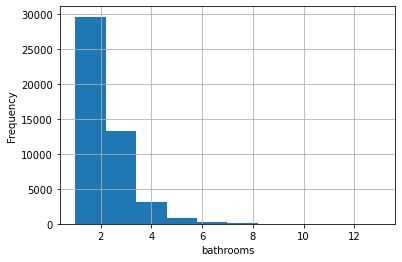

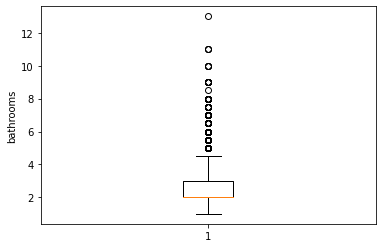

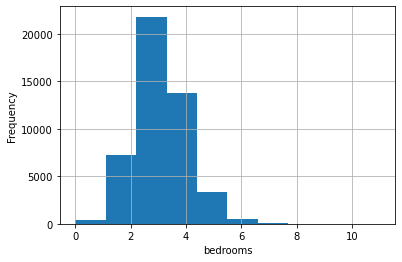

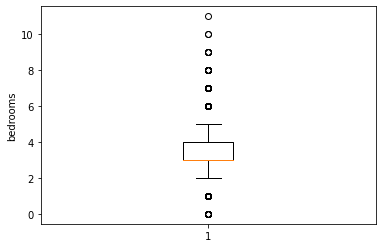

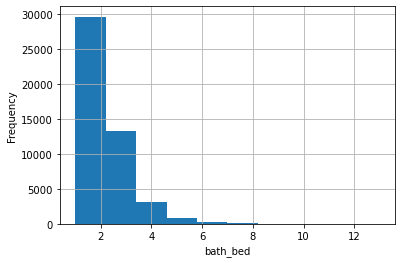

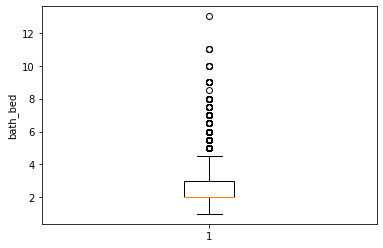

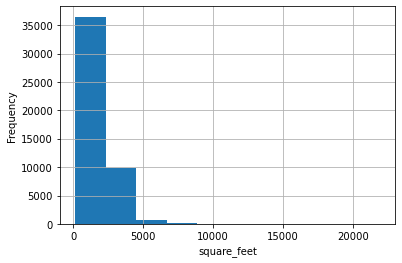

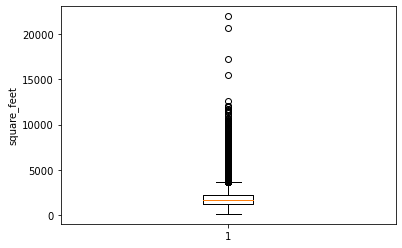

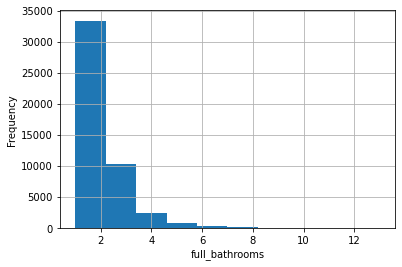

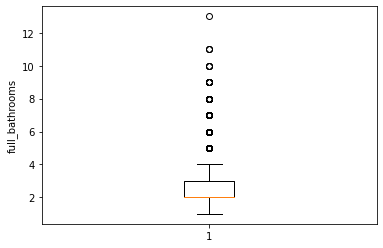

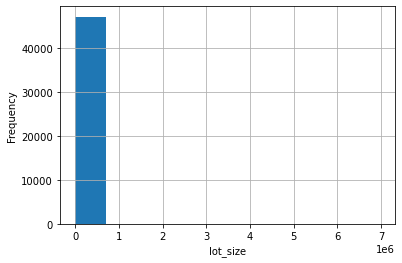

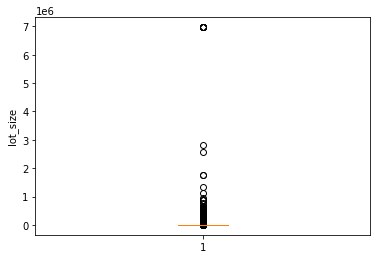

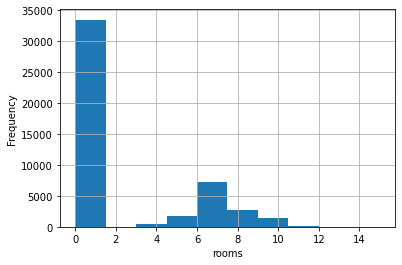

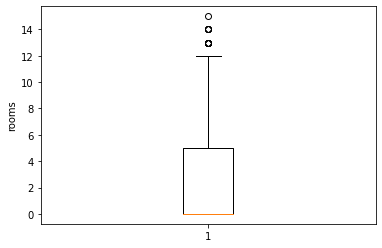

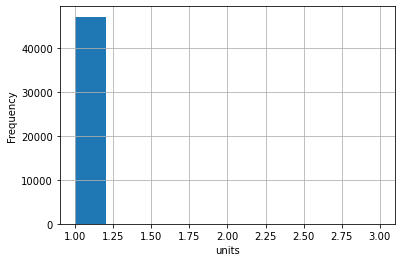

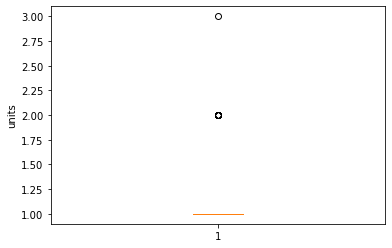

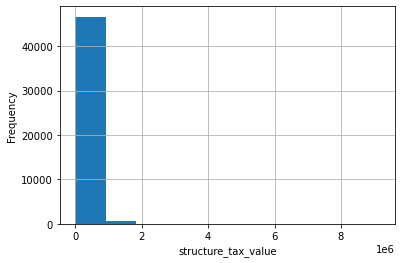

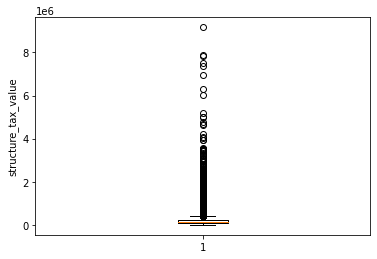

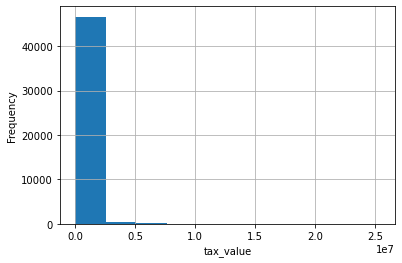

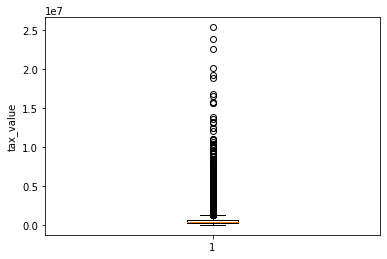

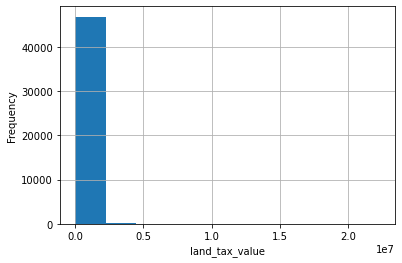

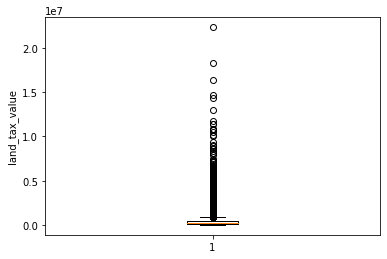

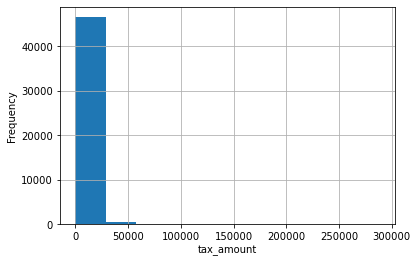

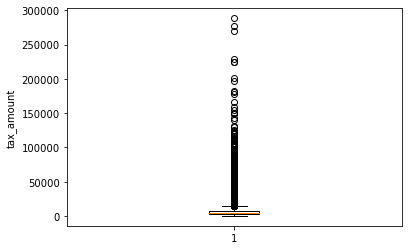

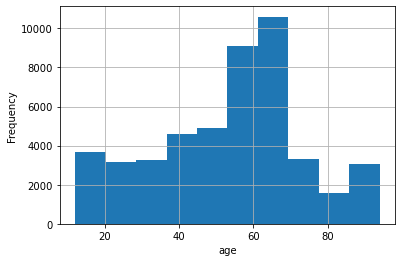

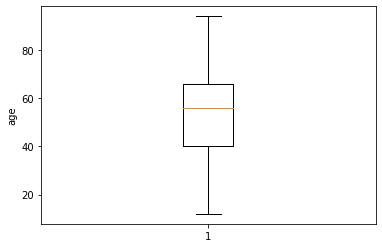

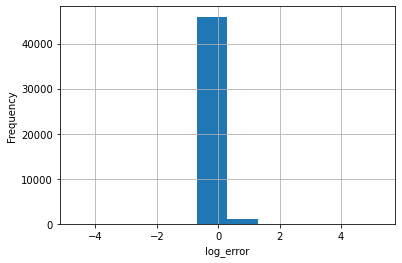

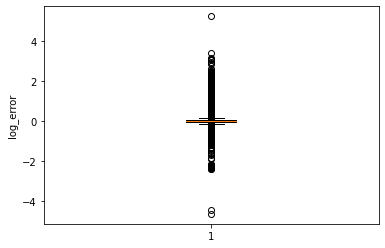

In [95]:
#loop through this list to view distributions of numeric columns
for cat in quant_vars:
    df[cat].hist()
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();
    plt.boxplot(df[cat])
    plt.ylabel(cat)
    plt.show();

Still a lot of outliers in this data set

In [96]:
#remove columns that have no outliers
outlier_drops = quant_vars.copy()

In [97]:
#verify lists
print(quant_vars)
print('--------')
print(outlier_drops)

['bathrooms', 'bedrooms', 'bath_bed', 'square_feet', 'full_bathrooms', 'lot_size', 'rooms', 'units', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'age', 'log_error']
--------
['bathrooms', 'bedrooms', 'bath_bed', 'square_feet', 'full_bathrooms', 'lot_size', 'rooms', 'units', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'age', 'log_error']


In [98]:
#remove columns from outlier list that don't need outlier removal
outlier_drops.remove('units')
outlier_drops.remove('age')
outlier_drops.remove('rooms')

In [99]:
#loop through the list of columns
for col in outlier_drops:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles
    
    iqr = q3 - q1   # calculate interquartile range
    
    upper_bound = q3 + 1.1 * iqr   # get upper bound
    lower_bound = q1 - 1.1 * iqr   # get lower bound
    
    dft = df[(df[col] > lower_bound) & (df[col] < upper_bound)] # generate dataframe without outliers
    
df = dft

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39767 entries, 12095076 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              39767 non-null  uint8  
 1   orange_county          39767 non-null  uint8  
 2   ventura_county         39767 non-null  uint8  
 3   heat_id                39767 non-null  float64
 4   transaction_id         39767 non-null  object 
 5   bathrooms              39767 non-null  float64
 6   bedrooms               39767 non-null  float64
 7   bath_bed               39767 non-null  float64
 8   square_feet            39767 non-null  float64
 9   fips_id                39767 non-null  int64  
 10  full_bathrooms         39767 non-null  float64
 11  latitude               39767 non-null  float64
 12  longitude              39767 non-null  float64
 13  lot_size               39767 non-null  float64
 14  property_landuse_code  39767 non-null  objec

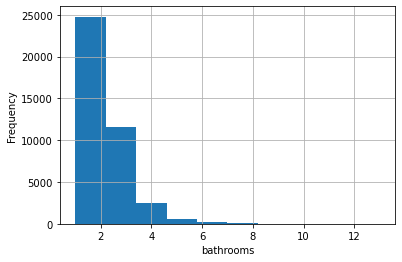

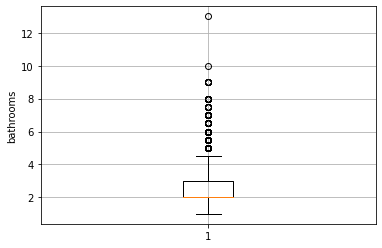

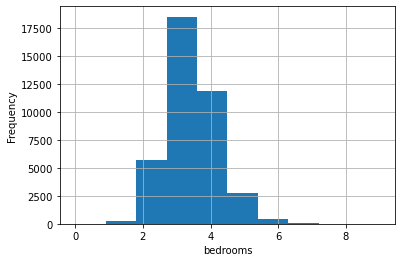

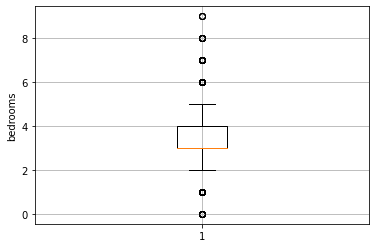

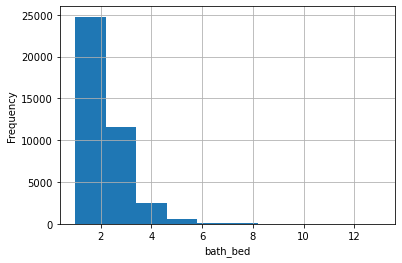

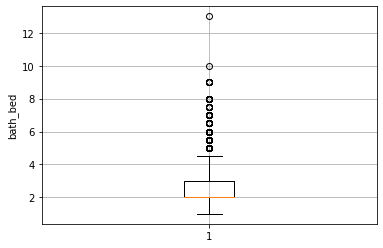

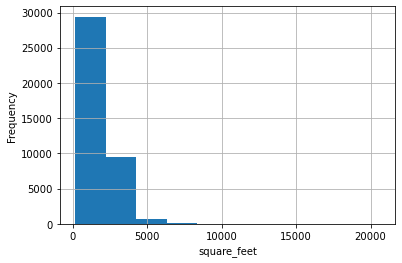

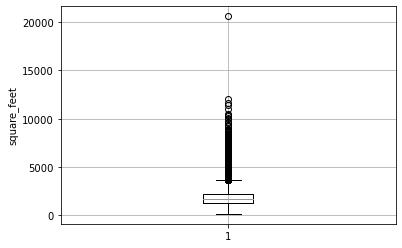

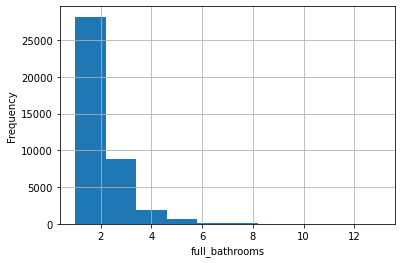

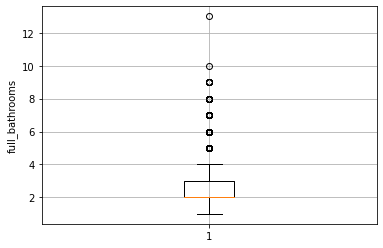

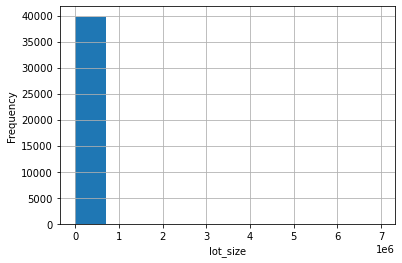

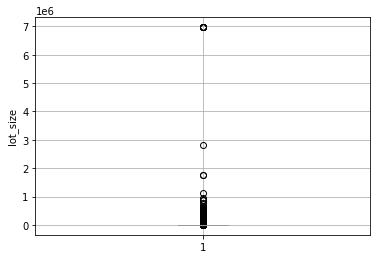

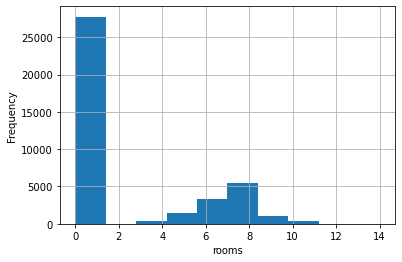

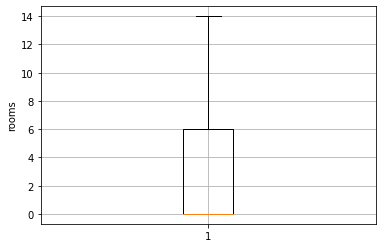

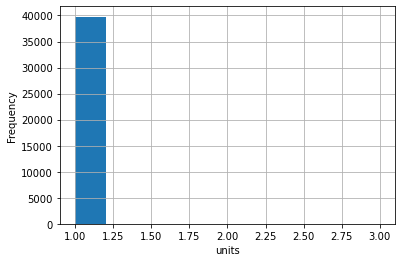

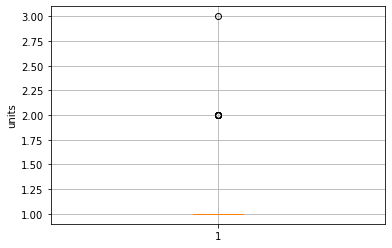

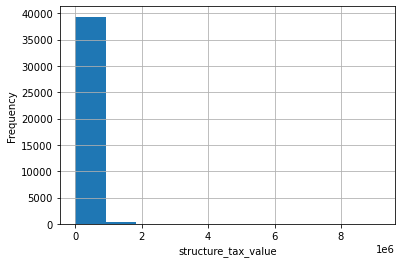

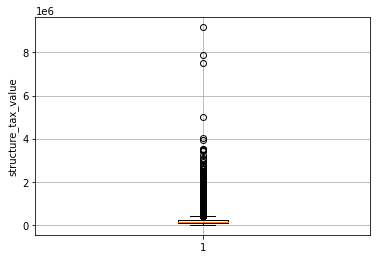

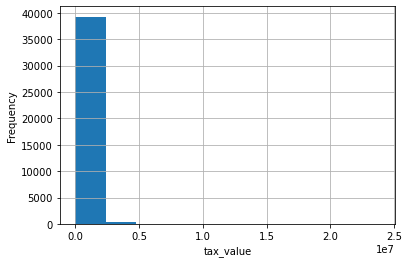

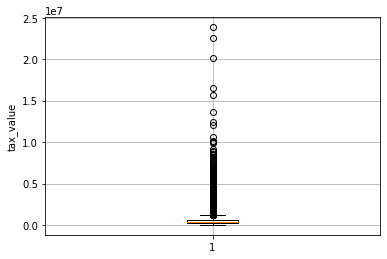

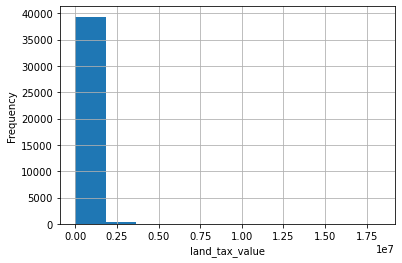

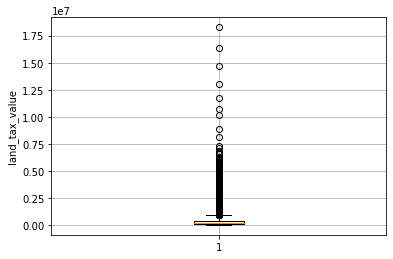

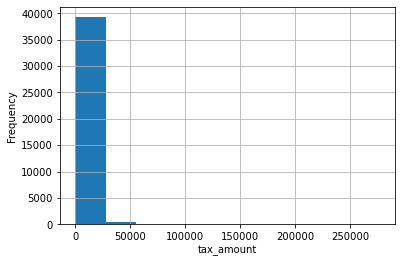

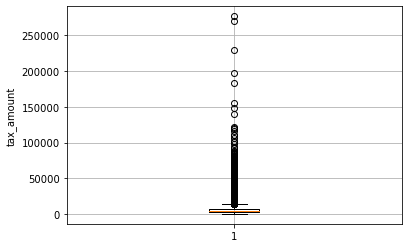

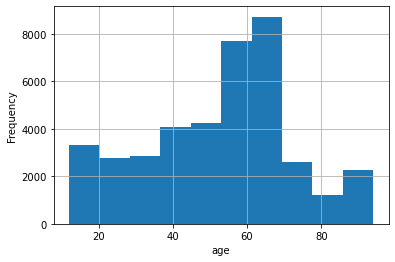

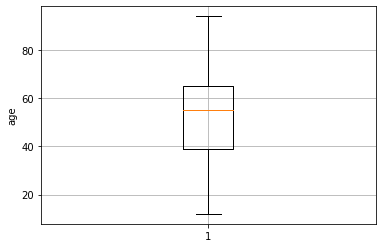

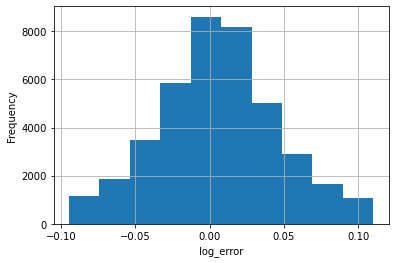

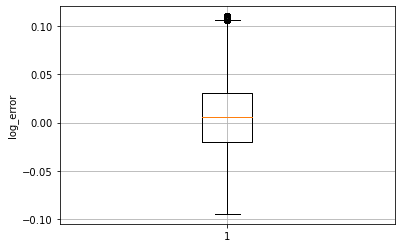

In [101]:
#loop through this list to view distributions of numeric columns after further outlier removal
for cat in quant_vars:
    df[cat].hist()
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();
    plt.boxplot(df[cat])
    plt.ylabel(cat)
    plt.grid(True)
    plt.show();

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39767 entries, 12095076 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              39767 non-null  uint8  
 1   orange_county          39767 non-null  uint8  
 2   ventura_county         39767 non-null  uint8  
 3   heat_id                39767 non-null  float64
 4   transaction_id         39767 non-null  object 
 5   bathrooms              39767 non-null  float64
 6   bedrooms               39767 non-null  float64
 7   bath_bed               39767 non-null  float64
 8   square_feet            39767 non-null  float64
 9   fips_id                39767 non-null  int64  
 10  full_bathrooms         39767 non-null  float64
 11  latitude               39767 non-null  float64
 12  longitude              39767 non-null  float64
 13  lot_size               39767 non-null  float64
 14  property_landuse_code  39767 non-null  objec

In [103]:
#loop through the list of columns
for col in outlier_drops:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles
    
    iqr = q3 - q1   # calculate interquartile range
    
    upper_bound = q3 + 1.365 * iqr   # get upper bound
    lower_bound = q1 - 1.365 * iqr   # get lower bound
    
    dft = df[(df[col] > lower_bound) & (df[col] < upper_bound)] # generate dataframe without outliers
    
df = dft

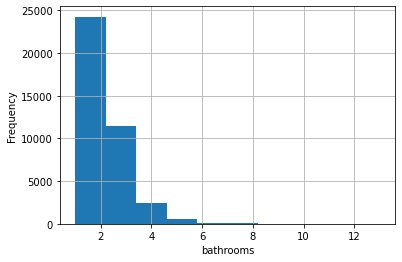

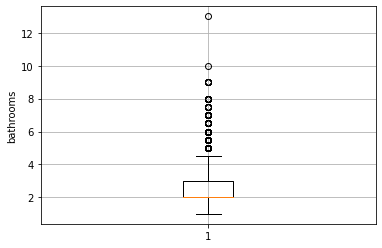

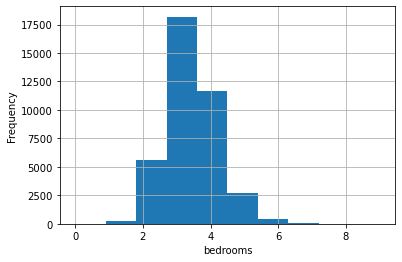

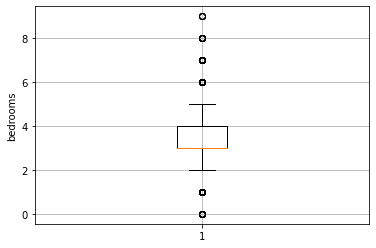

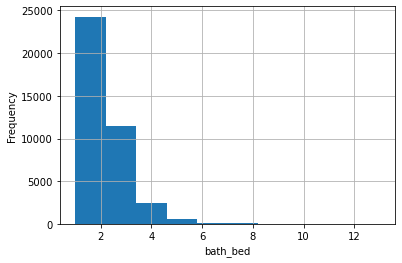

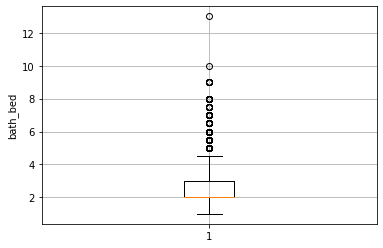

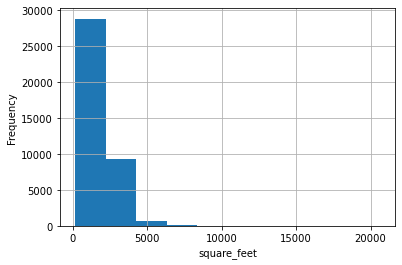

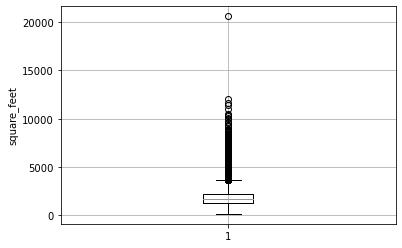

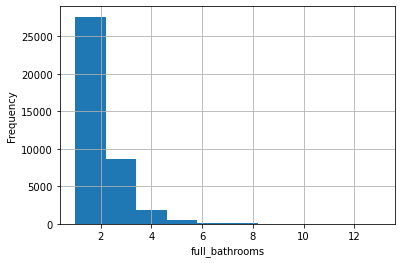

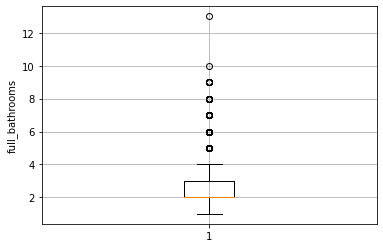

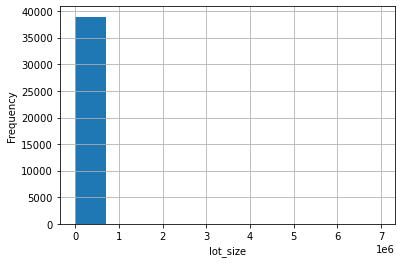

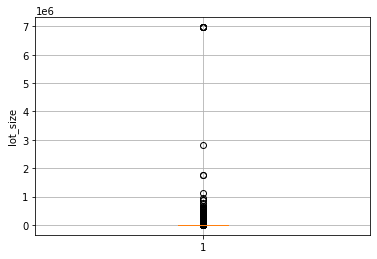

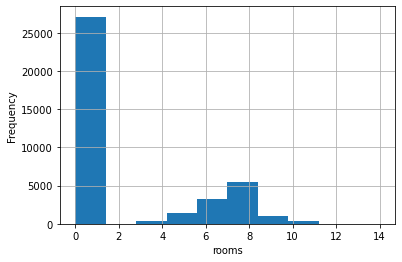

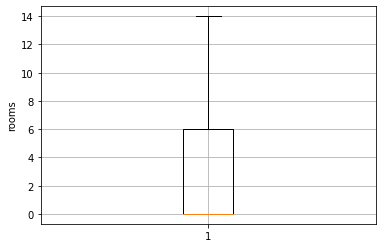

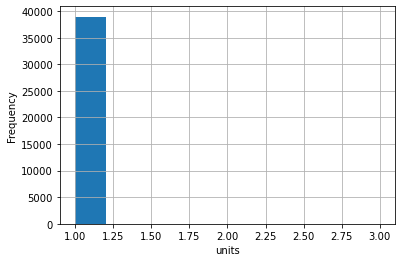

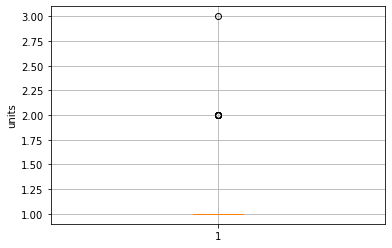

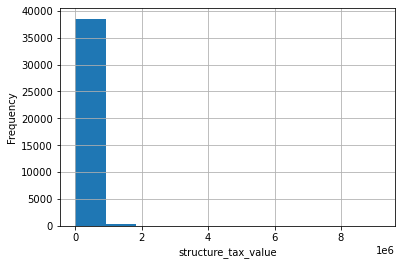

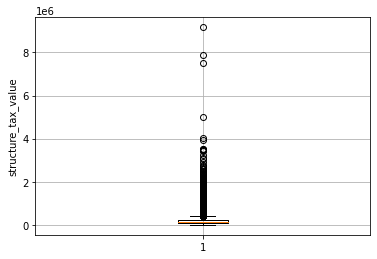

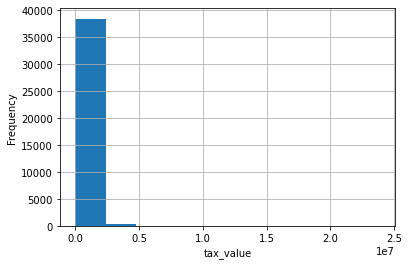

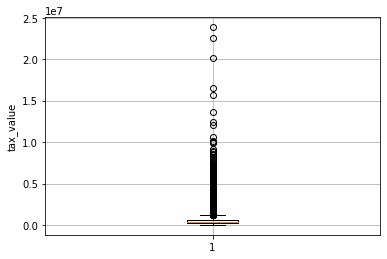

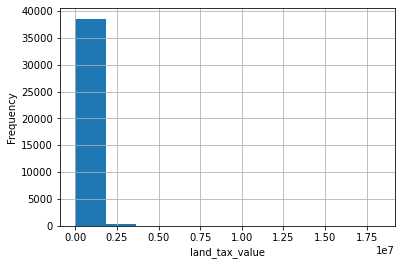

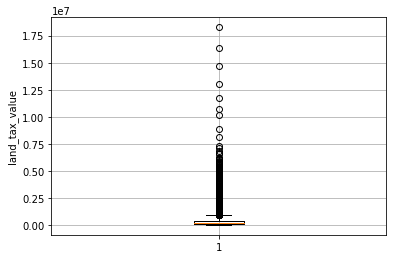

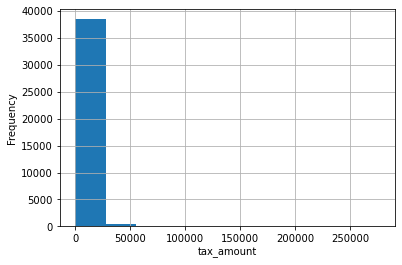

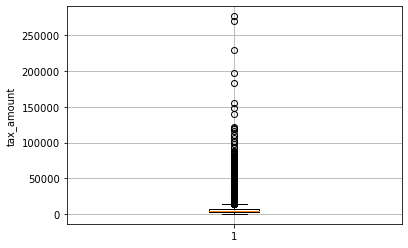

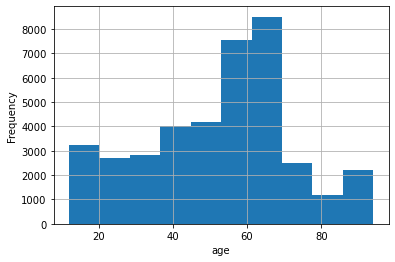

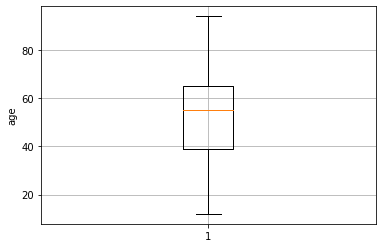

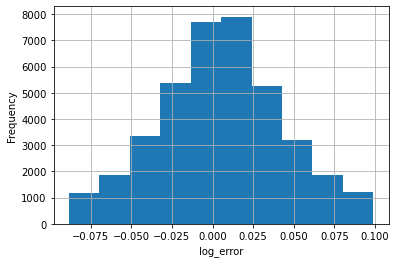

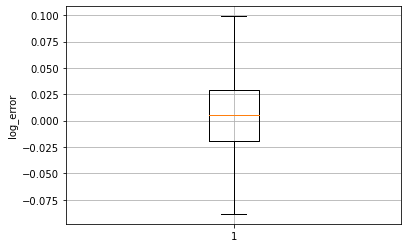

In [104]:
#loop through this list to view distributions of numeric columns after further outlier removal
for cat in quant_vars:
    df[cat].hist()
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();
    plt.boxplot(df[cat])
    plt.ylabel(cat)
    plt.grid(True)
    plt.show();

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38946 entries, 12095076 to 17239384
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              38946 non-null  uint8  
 1   orange_county          38946 non-null  uint8  
 2   ventura_county         38946 non-null  uint8  
 3   heat_id                38946 non-null  float64
 4   transaction_id         38946 non-null  object 
 5   bathrooms              38946 non-null  float64
 6   bedrooms               38946 non-null  float64
 7   bath_bed               38946 non-null  float64
 8   square_feet            38946 non-null  float64
 9   fips_id                38946 non-null  int64  
 10  full_bathrooms         38946 non-null  float64
 11  latitude               38946 non-null  float64
 12  longitude              38946 non-null  float64
 13  lot_size               38946 non-null  float64
 14  property_landuse_code  38946 non-null  objec

In [106]:
#remove target from scaling list
quant_vars.remove('log_error')

In [107]:
#split the data
train, validate, test = mf.split_data(df)

#scale the relevant data
train_scaled, validate_scaled, test_scaled, scaler = sc.robust_scaler(train, validate, test, quant_vars)

In [108]:
#juxtapose df shapes
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((21809, 13), (9347, 13), (7790, 13))

## Exploration

In [109]:
#pull up dataframe info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21809 entries, 12583749 to 14429328
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              21809 non-null  uint8  
 1   orange_county          21809 non-null  uint8  
 2   ventura_county         21809 non-null  uint8  
 3   heat_id                21809 non-null  float64
 4   transaction_id         21809 non-null  object 
 5   bathrooms              21809 non-null  float64
 6   bedrooms               21809 non-null  float64
 7   bath_bed               21809 non-null  float64
 8   square_feet            21809 non-null  float64
 9   fips_id                21809 non-null  int64  
 10  full_bathrooms         21809 non-null  float64
 11  latitude               21809 non-null  float64
 12  longitude              21809 non-null  float64
 13  lot_size               21809 non-null  float64
 14  property_landuse_code  21809 non-null  objec

In [110]:
#scaled training data at a glance
train_scaled.head()

,bathrooms,bedrooms,bath_bed,square_feet,full_bathrooms,lot_size,rooms,units,structure_tax_value,tax_value,land_tax_value,tax_amount,age
parcelid,,,,,,,,,,,,,
12583749,0.0,1.0,0.0,-0.141949,0.0,-0.583361,0.000000,0.0,-0.634652,-0.791546,-0.631130,-0.786784,-0.076923
17217789,1.5,0.0,1.5,1.784958,1.0,2.833943,1.333333,0.0,4.436675,2.771565,1.610954,2.516375,-1.500000
11270307,1.0,0.0,1.0,0.491525,1.0,1.181697,0.000000,0.0,0.201665,-0.235780,-0.300655,-0.115723,-0.807692
12991125,0.0,0.0,0.0,-0.580508,0.0,-0.257571,0.000000,0.0,-0.309358,-0.087110,0.099808,-0.035383,0.269231
14135452,0.5,0.0,0.5,0.090042,0.0,-1.453245,0.000000,0.0,1.106464,0.592409,0.336834,0.980871,-1.538462


In [111]:
#verify list of continuous variables
quant_vars.append('log_error')
print(quant_vars)
len(quant_vars)

['bathrooms', 'bedrooms', 'bath_bed', 'square_feet', 'full_bathrooms', 'lot_size', 'rooms', 'units', 'structure_tax_value', 'tax_value', 'land_tax_value', 'tax_amount', 'age', 'log_error']


14

### Explore Q I
##### What variables are linearly correlated? Do any features correlate with the target variable?

In [112]:
#compose lists of continuous variables such that no one can 
target = quant_vars[13]
first_corrs = quant_vars[:7] + [target]
second_corrs = quant_vars[7:14]

In [113]:
#look at first list
first_corrs

['bathrooms',
 'bedrooms',
 'bath_bed',
 'square_feet',
 'full_bathrooms',
 'lot_size',
 'rooms',
 'log_error']

In [114]:
#look at second list
second_corrs

['units',
 'structure_tax_value',
 'tax_value',
 'land_tax_value',
 'tax_amount',
 'age',
 'log_error']

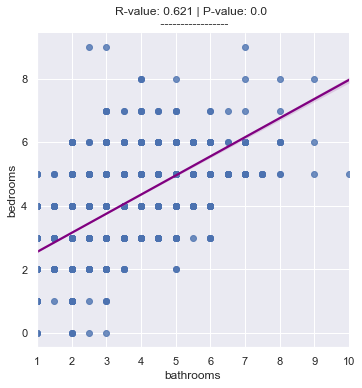

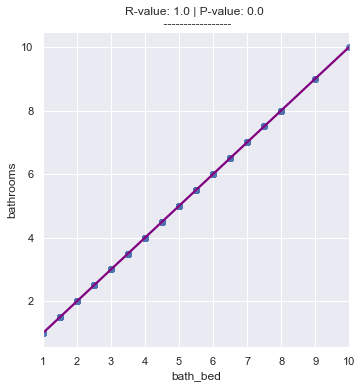

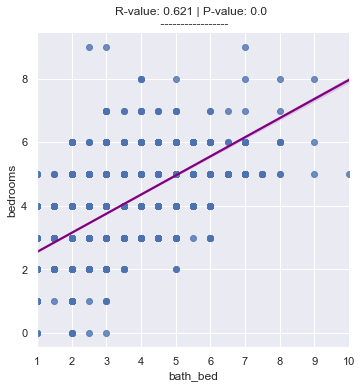

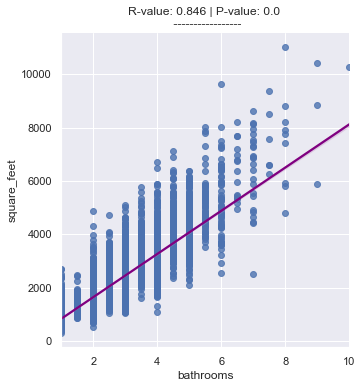

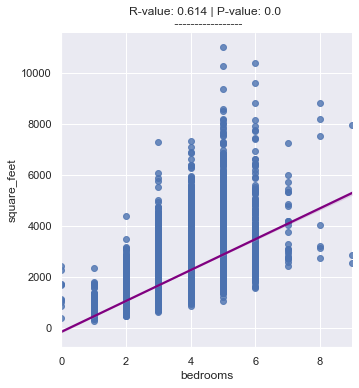

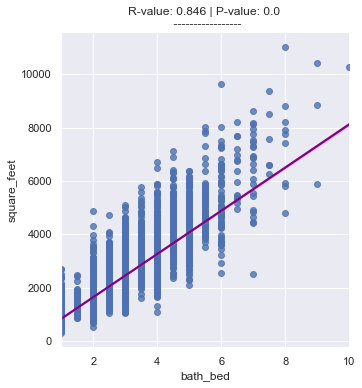

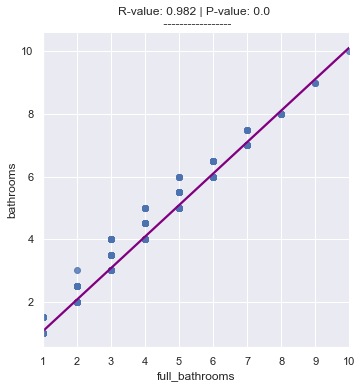

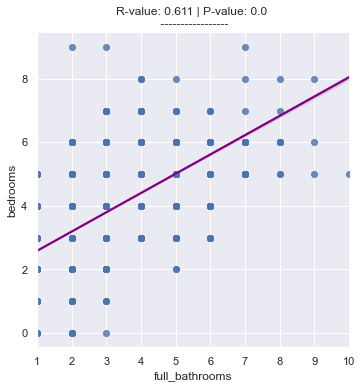

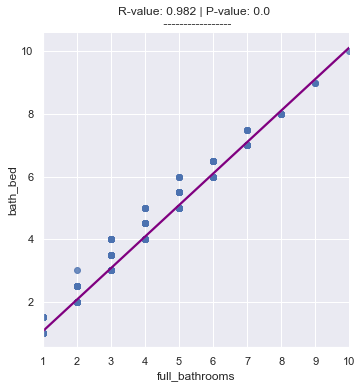

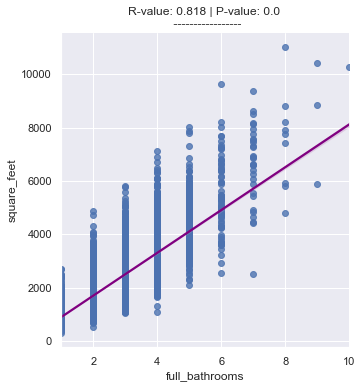

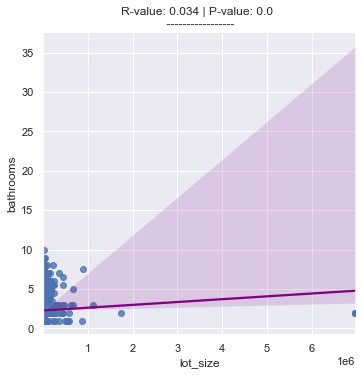

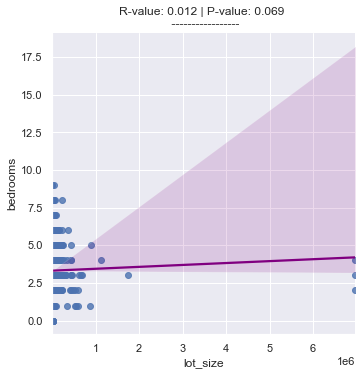

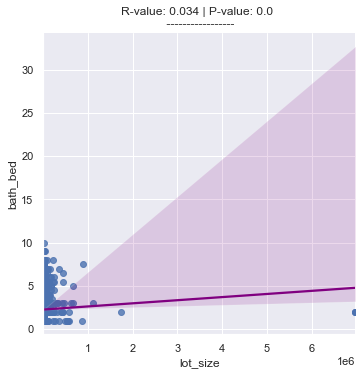

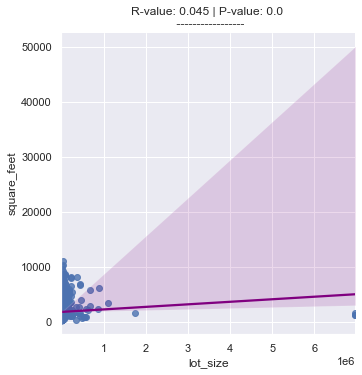

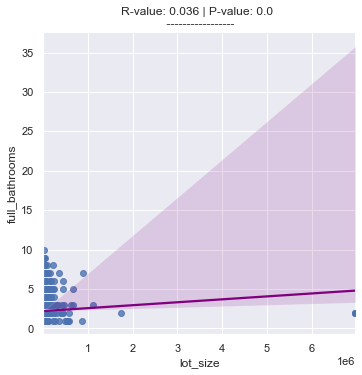

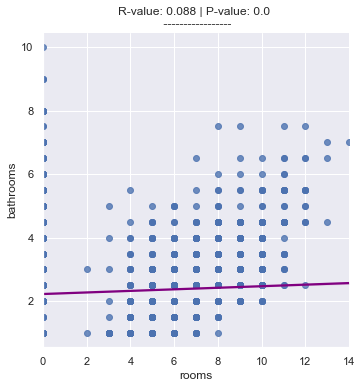

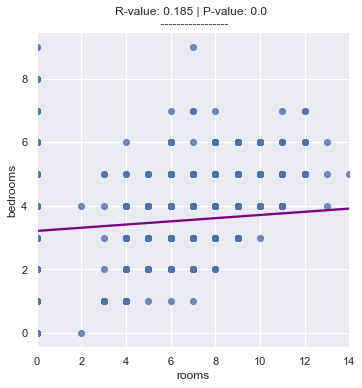

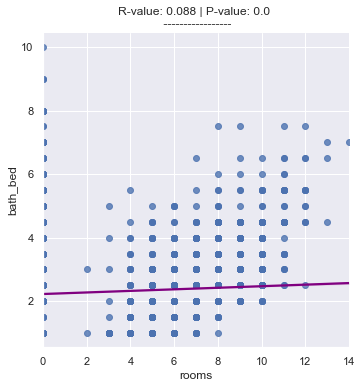

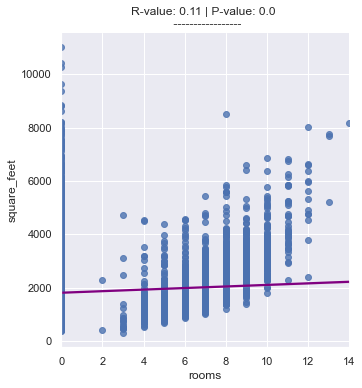

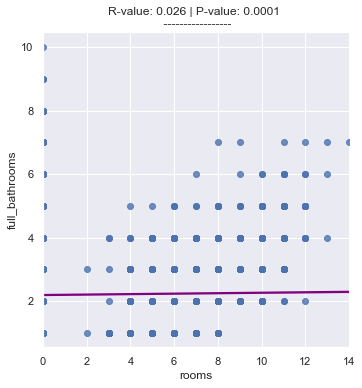

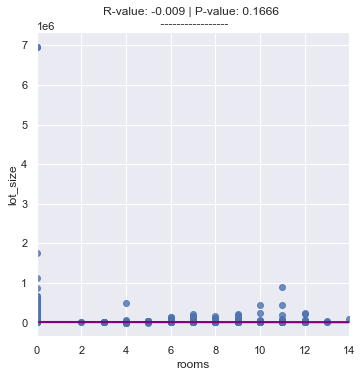

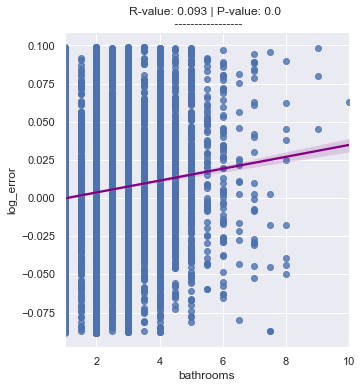

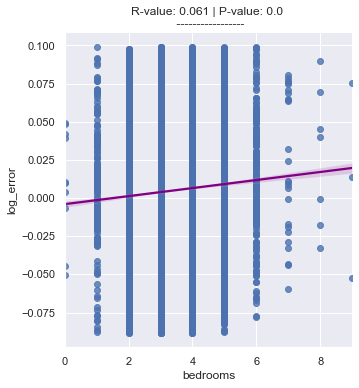

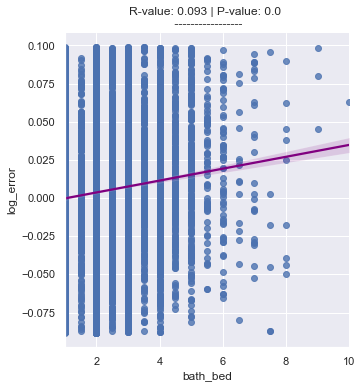

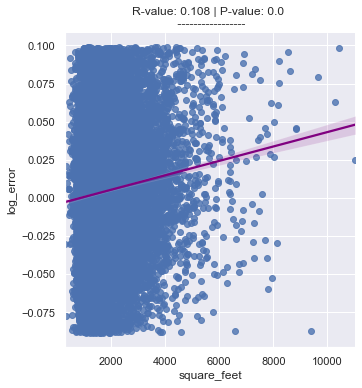

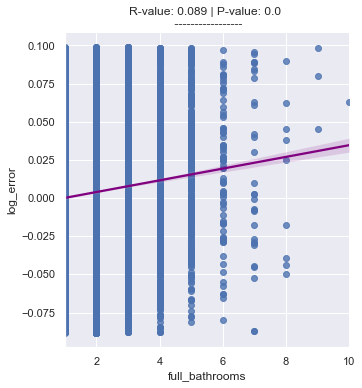

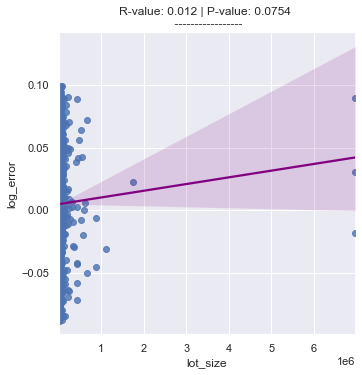

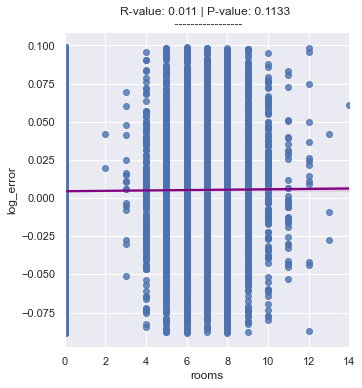

In [117]:
import explore

#plot linear correlations (if any) between continuous variables
explore.plot_variable_pairs(train, first_corrs)

### Takeaways
* bed/bath relationship has a decent correlation (.621 coefficient)
* square feet and bath/bed has a strong correlation (.846 coefficient)
* tiny correlation between bath/bed and lot size (.034)
* slightly bigger correlation between square feet and lot size (.045)
* slight correlation between bathrooms and rooms (.088)
* slightly bigger correlation between bedrooms and rooms (.185)
* slight correlation between square feet and rooms (.11)

#### Correlations with target
* tiny correlation between bathrooms and log error (.093)
* tiny correlation between bedrooms and log error (.061)
* slight correlation between square feet and log error (.108)

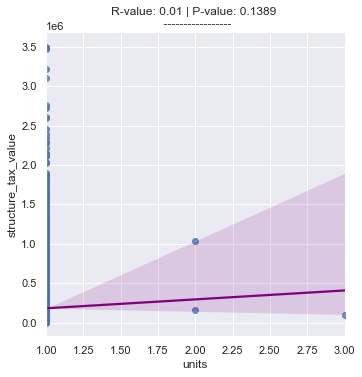

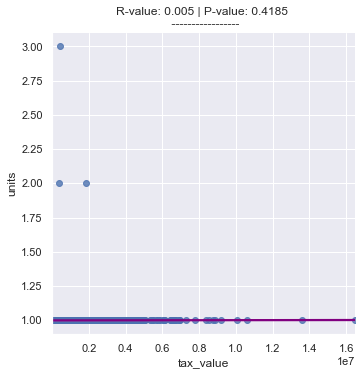

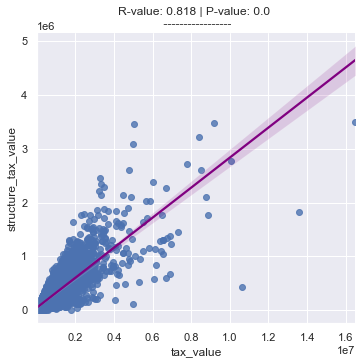

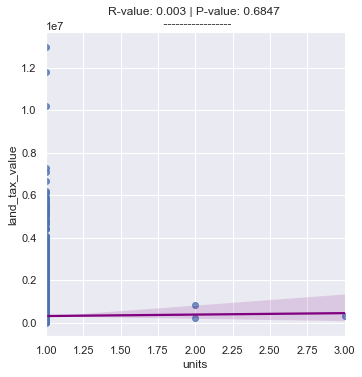

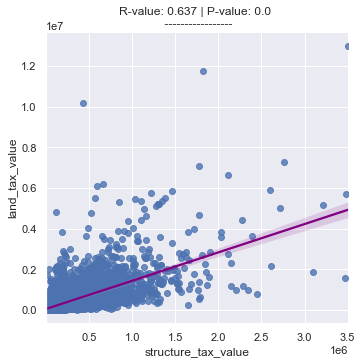

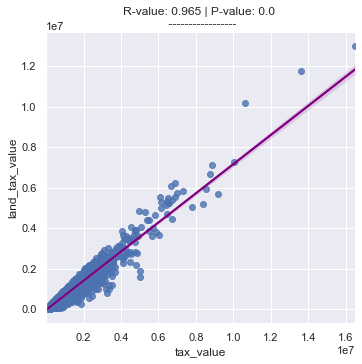

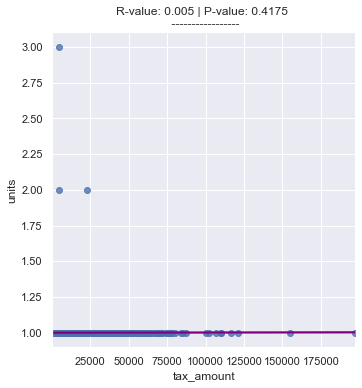

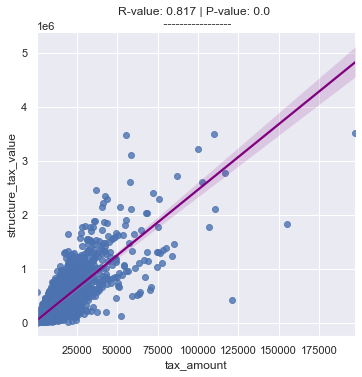

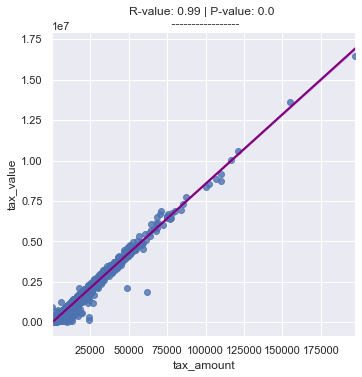

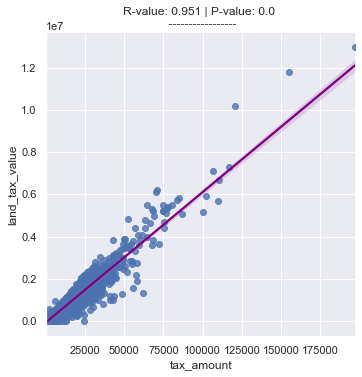

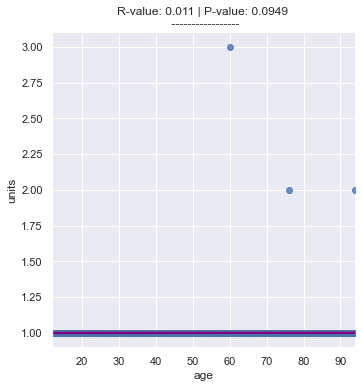

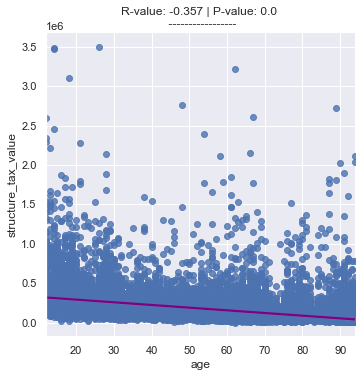

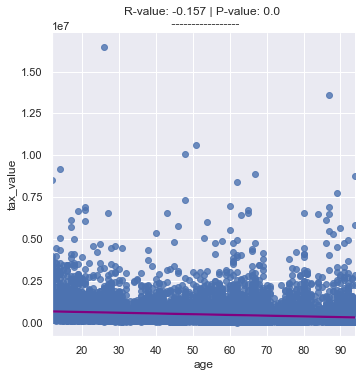

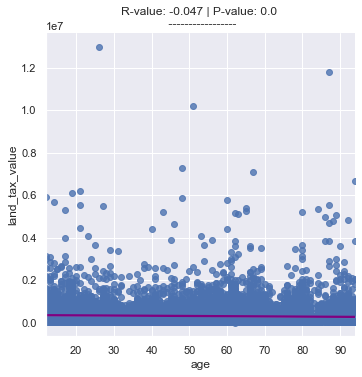

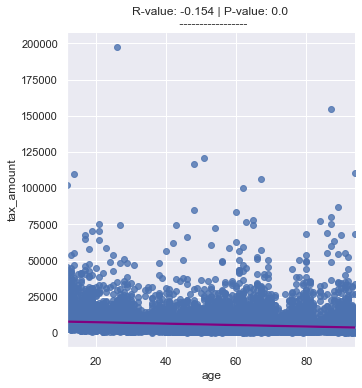

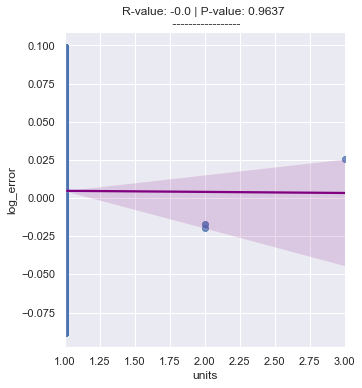

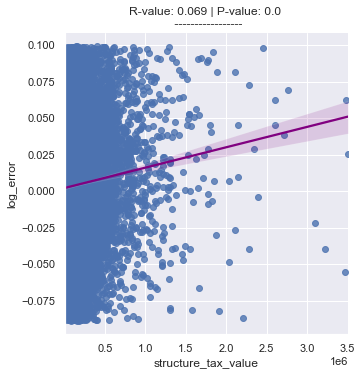

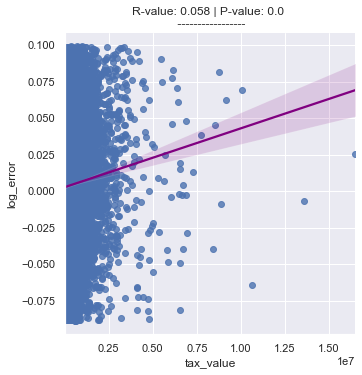

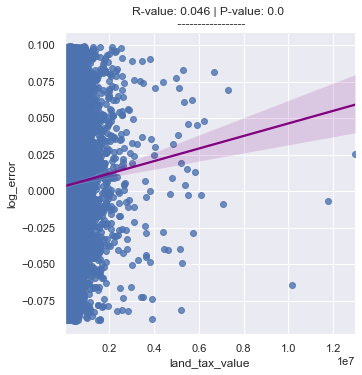

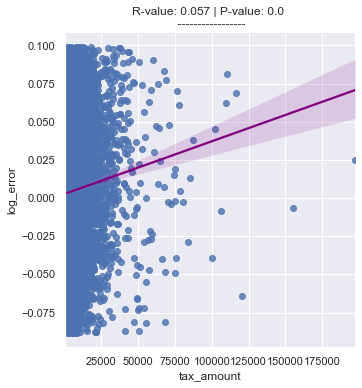

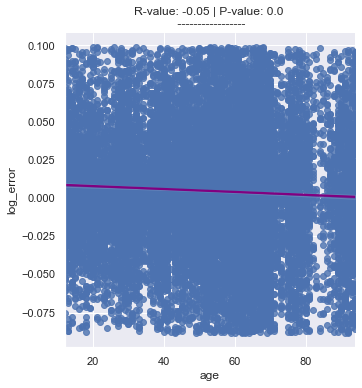

In [118]:
#plot more linear correlations
explore.plot_variable_pairs(train, second_corrs)

### Takeaways

* all tax values have strong correlations with one another (go figure) and the tax amount (duh)
* small correlation between tax value variables and age (around .29) including tax amount
* small negative correlation between age and structured tax value (-.357)
* tiny negative corelation between tax value and age (-.157)
* tiny negative correlation between land tax value and age (-.047)
* small negative correlation between tax amount and age (-.154)

#### Correlations with target
* tiny correlation between structured tax value and log error (.069)
* tiny correlation between tax value and log error (.058) (same correlation for tax amount and log error)
* tiny correlation between land tax value and log error (.046)
* tiny negative correlation between age and log error (-.05)

In [119]:
#another look at the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21809 entries, 12583749 to 14429328
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LA_county              21809 non-null  uint8  
 1   orange_county          21809 non-null  uint8  
 2   ventura_county         21809 non-null  uint8  
 3   heat_id                21809 non-null  float64
 4   transaction_id         21809 non-null  object 
 5   bathrooms              21809 non-null  float64
 6   bedrooms               21809 non-null  float64
 7   bath_bed               21809 non-null  float64
 8   square_feet            21809 non-null  float64
 9   fips_id                21809 non-null  int64  
 10  full_bathrooms         21809 non-null  float64
 11  latitude               21809 non-null  float64
 12  longitude              21809 non-null  float64
 13  lot_size               21809 non-null  float64
 14  property_landuse_code  21809 non-null  objec

### Explore Q II
#### Is log error the same in all of the counties?

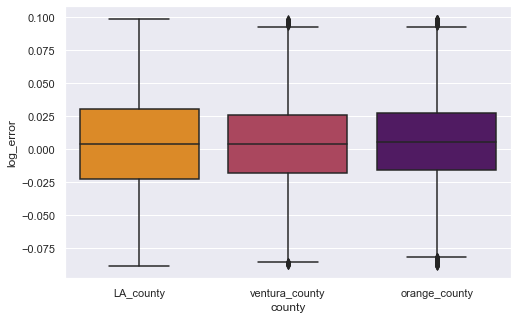

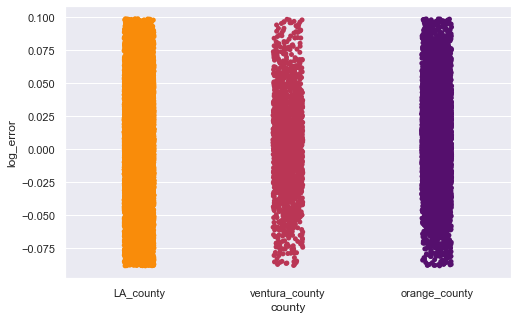

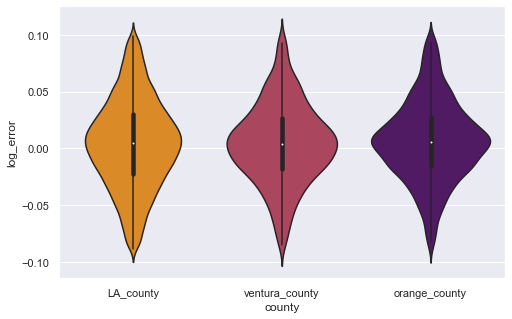

In [120]:
explore.plot_categorical_and_continuous(train, 'county', 'log_error')

### Takeaways
* log error looks pretty much the same across all 3 counties...but is it?

In [133]:
#pull up mean log error across counties
print(f'Average log error for LA county is: {train[train.county == "LA_county"].abs_logerror.mean()}')
print(f'Average log error for Ventura county is: {train[train.county == "ventura_county"].abs_logerror.mean()}')
print(f'Average log error for Orange county is: {train[train.county == "orange_county"].abs_logerror.mean()}')

Average log error for LA county is: 0.031804406881304564
Average log error for Ventura county is: 0.028043894212957755
Average log error for Orange county is: 0.02793504681583434


In [122]:
#assign variables to respective county data
los_angeles_county = train[train.county == 'LA_county']
ventura_county = train[train.county == 'ventura_county']
orange_county = train[train.county == 'orange_county']

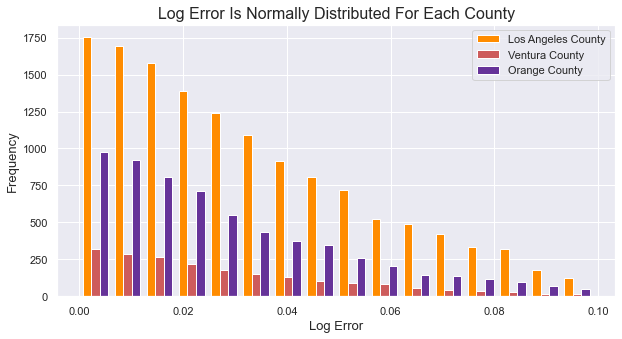

In [134]:
#visualize distribution target variable across different counties
plt.figure(figsize = (10, 5))
plt.hist([los_angeles_county.abs_logerror, ventura_county.abs_logerror, orange_county.abs_logerror],
         label = ['Los Angeles County', 'Ventura County', 'Orange County'],
         color = ['darkorange', 'indianred', 'rebeccapurple'],
         bins = 16
        )
plt.legend()
plt.title('Log Error Is Normally Distributed For Each County', size = 16, pad = 6)
plt.xlabel('Log Error', size = 13)
plt.ylabel('Frequency', size = 13);

It is no longer clear whether average log error across counties is significantly different or the same. I will run a T-Test after checking for homoscedasticity.

In [135]:
#variances at a glance
orange_county.abs_logerror.var(), los_angeles_county.abs_logerror.var()

(0.0005105471008446319, 0.0005666358532713205)

In [136]:
#run a levene test to look for homoscedasticity
stats.levene(orange_county.abs_logerror, los_angeles_county.abs_logerror)

LeveneResult(statistic=49.383804251258404, pvalue=2.1732033317511957e-12)

A low p-value on the levene test indicates the variances are different. They do not look much different to me, but I'm not intimately familiar with significant differences in log error.

#### Null hypothesis: The average log error for Orange County is the same or less as LA county.
#### Alternative hypothesis: The average log error for Orange County is signicantly greater than LA county.

In [137]:
#run a t-test with equal variances argument set to False
stats.ttest_ind(orange_county.abs_logerror, los_angeles_county.abs_logerror, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=-10.992319922382508, pvalue=1.0)

#### With a positive t-statistic and such a low p-value, I can confidently reject the null hypothesis that the log error for Orange County is the same or less as LA county.

#### What about Ventura County and Orange County?

#### Null hypothesis: The average log error for Orange County is the same or less as the average log error for Ventura county.
#### Alternative hypothesis: The average log error for Orange County is signicantly greater than Ventura county's.

In [138]:
#variances at a glance
orange_county.abs_logerror.var(), ventura_county.abs_logerror.var()

(0.0005105471008446319, 0.0004968101936619355)

In [139]:
#run a levene test to look for homoscedasticity
stats.levene(orange_county.abs_logerror, ventura_county.abs_logerror)

LeveneResult(statistic=0.019800617143287135, pvalue=0.8880988008780977)

The variances look the same, and the high p-value from the levene test indicates homoscedasticity

In [140]:
#run a t-test with equal variances
stats.ttest_ind(orange_county.abs_logerror, ventura_county.abs_logerror, alternative = 'greater')

Ttest_indResult(statistic=-0.18878043119950103, pvalue=0.574865218886782)

#### With a positive t stat and a low p-value, I can confidently reject the null hypothesis that the average log error for Orange County is the same or less as Ventura County's.

### Takeaways 
* Orange County's log error is significantly greater than the other counties' log error.

### Explore Q III
#### Does the type of heating system type affect log error?

#### Null hypothesis: The log error for all heating system types is the same.
#### Alternate hypothesis: The log error for all heating system types is not the same.

In [130]:
#pull up values for heat id
train.heat_id.value_counts()

2.0     13479
7.0      8036
6.0       264
20.0       11
13.0        9
1.0         5
18.0        4
10.0        1
Name: heat_id, dtype: int64

In [131]:
#focus on ids, 2, 6 and 7
heat2_log = train[train.heat_id == 2.0].log_error
heat6_log = train[train.heat_id == 6].log_error
heat7_log = train[train.heat_id == 7].log_error

In [132]:
#verify
heat6_log

parcelid
14481477    0.021605
17125373    0.042003
14017387   -0.017449
14254572    0.044716
14190324    0.025785
              ...   
14094746    0.007535
14038436    0.015897
14081445    0.055874
14448313    0.044845
13932442    0.071513
Name: log_error, Length: 264, dtype: float64

In [ ]:
#a glance at the average log error between popular heat systems
heat2_log.mean(), heat6_log.mean(), heat7_log.mean()

These definitely seem different to me based on my experience with average log error from above. Let's determine what kind of test(s) we will run.

Assumptions for T-Test and ANOVA:
* Normally distributed samples
* Independence of observations
* Equal variances

In [ ]:
#view distribution of log error
heat2_log.hist(color = 'darkgrey')
plt.title('Log Error Distribution for Central Heating')
plt.xlabel('Log Error')
plt.ylabel('Frequency');

In [ ]:
#view distribution of log error
heat6_log.hist(color = 'limegreen')
plt.title('Log Error Distribution for Forced Air')
plt.xlabel('Log Error')
plt.ylabel('Frequency');

In [ ]:
#view distribution of log error
heat2_log.hist(color = 'darkcyan')
plt.title('Log Error Distribution for Floor/ Wall System')
plt.xlabel('Log Error')
plt.ylabel('Frequency');

In [ ]:
#visualize distribution of target variable across popular heat systems
plt.figure(figsize = (13, 7))
plt.hist([heat2_log, heat6_log, heat7_log],
         label = ['Central', 'Forced Air', 'Floor/ Wall'],
         color = ['darkgrey', 'limegreen', 'darkcyan'],
         bins = 15
        )
plt.legend()
plt.title('Log Error for Popular Heating Systems is Normally Distributed Enough', size = 16, pad = 7)
plt.xlabel('Log Error')
plt.ylabel('Frequency');

* All observations are independent of each other
* All samples are normally distributed enough

In [ ]:
#variances at a glance
heat2_log.var(), heat6_log.var(), heat7_log.var()

In [ ]:
#run a bartlett test to check for homoscedasticity
stats.bartlett(heat2_log, heat6_log)

The high p-value indicates these variances are not significantly different.

In [ ]:
#run bartlett on Central and Floor/ Wall (more normally distributed samples)
stats.bartlett(heat2_log, heat7_log)

Low p-value indicates different variances

In [ ]:
#run bartlett's on Forced Air and Floor/ Wall
stats.bartlett(heat6_log, heat7_log)

Low p-value indicates I can reject the null hypothesis that the variances are the same.

#### Null hypothesis: Log error is the same across all heat systems.
#### Alternate hypothesis: Log error is not the same across heat systems.

In [ ]:
#run a kruskal test since variances are different
stats.kruskal(heat2_log, heat6_log, heat7_log)

#### The non-parametric Kruskal test's low p-value indicates I can reject the null hypothesis that log error is the same across the different heating systems. The log error means among heating systems are significantly different from one another.

Where is the log error significantly different?

Let's check Forced Air and Central

#### Null hypothesis: The log error for forced air is the same or less as central.
#### Alternate hypothesis: The log error for forced air is more than central.

In [ ]:
#testing
stats.ttest_ind(heat6_log, heat2_log, equal_var = False, alternative = 'greater')

#### High p-value (.333) means I fail to reject my null hypothesis that log error is the same between central heating systems and forced air systems. The difference in log error between the two is not significantly different.

Let's look at Forced Air and Floor/ Wall

#### Null hypothesis: Log error for forced air is the same or less as floor/ wall.
#### Alternate hypothesis: Log error for forced air is greater than floor/ wall.

In [ ]:
stats.ttest_ind(heat6_log, heat7_log, equal_var = False, alternative = 'greater')

#### Low p-value (.016) indicates I can reject the null hypothesis that the log error is the same or less between forced air and floor/ wall.

Let's look at Central and Floor/ Wall

#### Null hypothesis: The log error for central heating is the same or less as floor/ wall systems' log error.
#### Alternate hypothesis: The log error for central heating is greater than floor/ wall systems' log error.

In [ ]:
stats.ttest_ind(heat2_log, heat7_log, equal_var = False, alternative = 'greater')

#### Low p-value indicates I can reject my null hypothesis that log error is the same or less between central and floor/ wall. There is a significant difference in log error.